Import Library

In [1]:
import os
import sys
import requests
sys.path.append(os.path.join(os.getcwd(), "SwinIR")) # setting directory to ensure it recognizes the SwinIR github folder

In [3]:
import torch
import random
import shutil
from PIL import Image

from basicsr.archs.swinir_arch import SwinIR # if this throws an error, try re running block 1 again
import torch.nn.functional as F

from torchvision import transforms, datasets

Transform

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize image to 224 x 224
    transforms.ToTensor(), # convert image to tensor [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) # normalize to [-1, 1] for CNN
])

Load Full Dataset

In [5]:
full_dataset = datasets.ImageFolder(
    root="data",
    transform=transform
)
print("Class to index mapping:", full_dataset.class_to_idx)
len(full_dataset)

Class to index mapping: {'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2}


15153

Sample the images

In [6]:
input_directory = "data"
output_directory = "data_subset"
subset_size = 1500

if os.path.exists(output_directory): # if the output directory exist, override it
    shutil.rmtree(output_directory)
os.makedirs(output_directory)

all_images = []

for i in os.listdir(input_directory): # for every classes folder (COVID, Normal, Viral Pneumonia)
    class_path = os.path.join(input_directory, i) # combine into one directory: the root directory with the class directory
    if not os.path.isdir(class_path): # if it's not a directory, pass
        continue

    for j in os.listdir(class_path): # for every file in the classes folder
        if j.lower().endswith(('.jpg', '.jpeg', '.png')): # if the file is an image
            full_path = os.path.join(class_path, j) # combine into one directory: the full class directory and the image directory
            all_images.append((full_path, i)) # append to all_images list

random.seed(586)  # set seed for reproducibility
sampled_images = random.sample(all_images, subset_size) # random sample x images from the list

for path, class_name in sampled_images:
    destination_folder = os.path.join(output_directory, class_name) # new directory path
    os.makedirs(destination_folder, exist_ok=True) # make the directory
    shutil.copy(path, os.path.join(destination_folder, os.path.basename(path))) # copy the file from the original input_directory into the output_directory

print(f"Subset of {subset_size} images completed. Saved to {output_directory}")

Subset of 1500 images completed. Saved to data_subset


Downsampling (reduce resolution) Images

In [7]:
input_directory = "data_subset"
output_directory = "data_subset_lowres"
target_size = (56, 56)

for i in os.listdir(input_directory): # for every classes folder (COVID, Normal, Viral Pneumonia)
    class_path = os.path.join(input_directory, i) # identify the current path
    destination_path = os.path.join(output_directory, i) # identify the destination path
    
    if not os.path.isdir(class_path): # if it is not a path, pass
        continue
    
    if os.path.exists(destination_path): # if the destination path already existed, override its content
        shutil.rmtree(destination_path) 
    os.makedirs(destination_path) # make the directory

    for j in os.listdir(class_path): # for every file in the classes folder
        if not j.endswith('.jpg') and not j.endswith('.png'): # if the file is not an image, pass
            continue

        image_path = os.path.join(class_path, j) # create a new path
        image = Image.open(image_path).convert("RGB") # open the image file and store it as image variable
        image = image.resize(target_size, resample=Image.BICUBIC) # resize
        image.save(os.path.join(destination_path, j)) # save the image

print("Downsampling complete. Saved to 'data_subset_lowres'")

Downsampling complete. Saved to 'data_subset_lowres'


SwinIR on Reduced Resolution

In [8]:
url = "https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth"
save_path = "SwinIR/model_zoo/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)

if not os.path.exists(save_path):
    print("Downloading pretrained SwinIR model weights...")
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)
    print("Download complete.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # FOR WINDOWS
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # FOR MAC

swinir_model = SwinIR(
    upscale=4, # we want to upscale 4 times (from downscaled 56x56 to the original 224x224)
    in_chans=3, # default 3 channels for RGB
    img_size=48, # based on paper
    window_size=8, # based on paper
    img_range=1.0, # pixel range of the images [0, 1]
    depths=[6, 6, 6, 6, 6, 6], # according to the pretrained model github
    embed_dim=180, # according to the pretrained model github
    num_heads=[6, 6, 6, 6, 6, 6], # according to the pretrained model github
    mlp_ratio=2, # default
    upsampler='pixelshuffle', # default
    resi_connection='1conv' # default
)

weights_path = "SwinIR/model_zoo/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth" # pretrain model weights
checkpoint = torch.load(weights_path)
swinir_model.load_state_dict(checkpoint['params'], strict=True)
swinir_model.eval().to(device)

to_tensor = transforms.ToTensor() # PIL to Tensor
to_pil = transforms.ToPILImage() # Tensor to PIL

input_directory = "data_subset_lowres"
output_directory = "data_subset_lowres_swinir"
window_size = 8 # required by SwinIR to be divisible by 8

for i in os.listdir(input_directory): # for every classes folder (COVID, Normal, Viral Pneumonia)
    class_path = os.path.join(input_directory, i) # identify the path
    destination_path = os.path.join(output_directory, i) # identify the destination path

    if not os.path.isdir(class_path): # if it's not a directory, pass
        continue
    
    if os.path.exists(destination_path): # if the destination path already existed, override its content 
        shutil.rmtree(destination_path) 
    os.makedirs(destination_path) # make the directory

    for j in os.listdir(class_path): # for every file in the classes folder
        if not j.lower().endswith(('.jpg', '.png', '.jpeg')): # if it's not an image, pass
            continue

        image = Image.open(os.path.join(class_path, j)).convert("RGB") # store the current image into a variable
        image_tensor = to_tensor(image).unsqueeze(0).to(device)

        # padding
        _, _, h, w = image_tensor.size() 
        pad_h = (window_size - h % window_size) % window_size 
        pad_w = (window_size - w % window_size) % window_size
        image_tensor = F.pad(image_tensor, (0, pad_w, 0, pad_h), mode='reflect')

        with torch.no_grad():
            sr_tensor = swinir_model(image_tensor).clamp(0, 1) # running swinir

        swinir_image = to_pil(sr_tensor.squeeze(0).cpu())
        swinir_image.save(os.path.join(destination_path, j))

print("SwinIR complete. Saved to 'data_subset_lowres_swinir'") # should take around 2.5 - 3.5 minutes on Windows. 7 - 8 minutes on Mac.

Download complete.


c:\Users\kirki\miniconda3\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinIR complete. Saved to 'data_subset_lowres_swinir'


SwinIR on Original Resolution

In [9]:
url = "https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth"
save_path = "SwinIR/model_zoo/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)

if not os.path.exists(save_path):
    print("Downloading pretrained SwinIR model weights...")
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)
    print("Download complete.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # FOR WINDOWS
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # FOR MAC

swinir_model = SwinIR(
    upscale=4, # we want to upscale 4 times
    in_chans=3, # default 3 channels for RGB
    img_size=48, # based on paper
    window_size=8, # based on paper
    img_range=1.0, # pixel range of the images [0, 1]
    depths=[6, 6, 6, 6, 6, 6], # according to the pretrained model github
    embed_dim=180, # according to the pretrained model github
    num_heads=[6, 6, 6, 6, 6, 6], # according to the pretrained model github
    mlp_ratio=2, # default
    upsampler='pixelshuffle', # default
    resi_connection='1conv' # default
)

weights_path = "SwinIR/model_zoo/001_classicalSR_DIV2K_s48w8_SwinIR-M_x4.pth" # pretrain model weights
checkpoint = torch.load(weights_path)
swinir_model.load_state_dict(checkpoint['params'], strict=True)
swinir_model.eval().to(device)

to_tensor = transforms.ToTensor() # PIL to Tensor
to_pil = transforms.ToPILImage() # Tensor to PIL

input_directory = "data_subset"
output_directory = "data_subset_original_swinir"
window_size = 8 # required by SwinIR to be divisible by 8

for i in os.listdir(input_directory): # for every classes folder (COVID, Normal, Viral Pneumonia)
    class_path = os.path.join(input_directory, i) # identify the path
    destination_path = os.path.join(output_directory, i) # identify the destination path

    if not os.path.isdir(class_path): # if it's not a directory, pass
        continue
    
    if os.path.exists(destination_path): # if the destination path already existed, override its content 
        shutil.rmtree(destination_path) 
    os.makedirs(destination_path) # make the directory

    for j in os.listdir(class_path): # for every file in the classes folder
        if not j.lower().endswith(('.jpg', '.png', '.jpeg')): # if it's not an image, pass
            continue

        image = Image.open(os.path.join(class_path, j)).convert("RGB") # store the current image into a variable
        image_tensor = to_tensor(image).unsqueeze(0).to(device)

        # padding
        _, _, h, w = image_tensor.size() 
        pad_h = (window_size - h % window_size) % window_size 
        pad_w = (window_size - w % window_size) % window_size
        image_tensor = F.pad(image_tensor, (0, pad_w, 0, pad_h), mode='reflect')

        with torch.no_grad():
            sr_tensor = swinir_model(image_tensor).clamp(0, 1) # running swinir

        swinir_image = to_pil(sr_tensor.squeeze(0).cpu())
        swinir_image.save(os.path.join(destination_path, j))

print("SwinIR complete. Saved to 'data_subset_original_swinir'") # should take around 2.5 - 3.5 minutes on Windows. 7 - 8 minutes on Mac.

SwinIR complete. Saved to 'data_subset_original_swinir'


CNN Classifier

In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# setup
data_dir = "data_subset"
lowres_dir = "data_subset_lowres"
enhanced_dir_lowres = "data_subset_lowres_swinir"
enhanced_dir_og = "data_subset_original_swinir"
batch_size = 32
img_size = 224
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# data loading
original_dataset = ImageFolder(root=data_dir, transform=transform)
lowres_dataset = ImageFolder(root=lowres_dir, transform=transform)
enhanced_dataset_lowres = ImageFolder(root=enhanced_dir_lowres, transform=transform)
enhanced_dataset_og = ImageFolder(root=enhanced_dir_og, transform=transform)

# sorting for split stuff
original_dataset.samples.sort()
lowres_dataset.samples.sort()
enhanced_dataset_lowres.samples.sort()
enhanced_dataset_og.samples.sort()

# creating consistent split
np.random.seed(586)
indices = np.arange(len(original_dataset))
np.random.shuffle(indices)
train_size = int(0.8 * len(indices))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# subset data with splits
original_train = Subset(original_dataset, train_indices)
original_test = Subset(original_dataset, test_indices)
lowres_train = Subset(lowres_dataset, train_indices)
lowres_test = Subset(lowres_dataset, test_indices)
enhanced_train_lowres = Subset(enhanced_dataset_lowres, train_indices)
enhanced_test_lowres = Subset(enhanced_dataset_lowres, test_indices)
enhanced_train_og = Subset(enhanced_dataset_og, train_indices)
enhanced_test_og = Subset(enhanced_dataset_og, test_indices)

# loading data
original_train_loader = DataLoader(original_train, batch_size=batch_size, shuffle=True)
original_test_loader = DataLoader(original_test, batch_size=batch_size)
lowres_train_loader = DataLoader(lowres_train, batch_size=batch_size, shuffle=True)
lowres_test_loader = DataLoader(lowres_test, batch_size=batch_size)
enhanced_train_lowres_loader = DataLoader(enhanced_train_lowres, batch_size=batch_size, shuffle=True)
enhanced_test_lowres_loader = DataLoader(enhanced_test_lowres, batch_size=batch_size)
enhanced_train_og_loader = DataLoader(enhanced_train_og, batch_size=batch_size, shuffle=True)
enhanced_test_og_loader = DataLoader(enhanced_test_og, batch_size=batch_size)

# super basic CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (img_size // 4) * (img_size // 4), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# train/eval model
def train_and_evaluate(train_loader, test_loader, dataset_name, class_names): # added class names so we actually know which image set label from
    model = SimpleCNN(num_classes=len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    print(f"\nTraining on {dataset_name} dataset:")
    for epoch in range(num_epochs):
        
        # training
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Evaluation
        model.eval()
        running_test_loss = 0
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_test_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # confusion matrix
        cm = confusion_matrix(all_labels, all_predicted)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
                    xticklabels = class_names, yticklabels = class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - Epoch {epoch+1} - {dataset_name}')
        plt.show()

    return train_losses, train_accuracies, test_losses, test_accuracies


Training on Original dataset:
Epoch 1: Train Loss: 0.8187, Accuracy: 0.6842


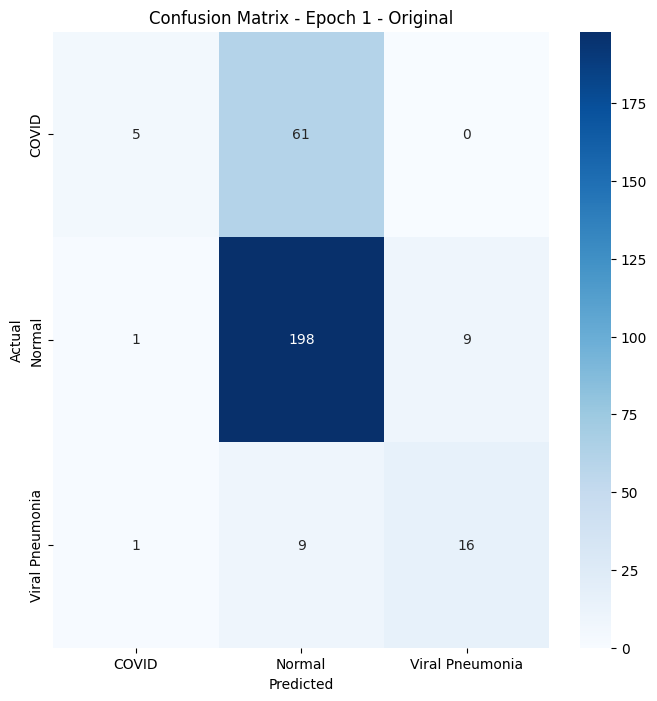

Epoch 2: Train Loss: 0.5338, Accuracy: 0.7475


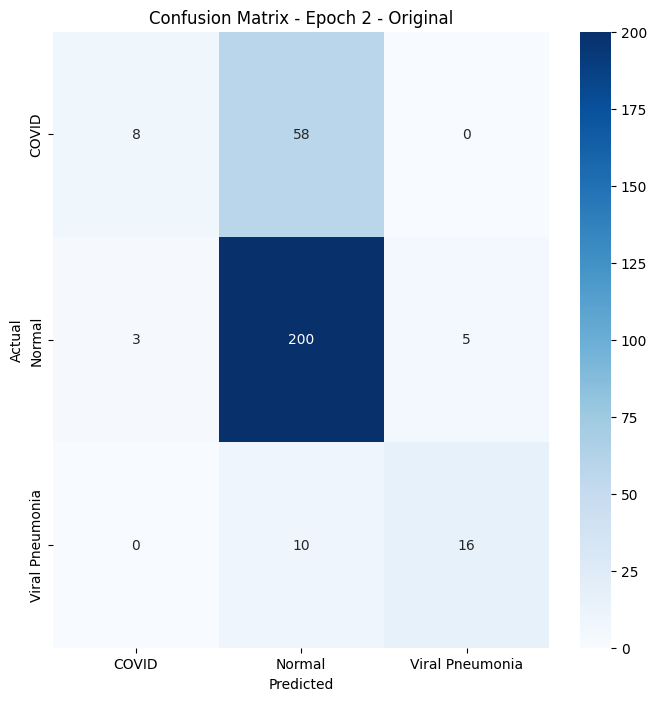

Epoch 3: Train Loss: 0.5037, Accuracy: 0.7650


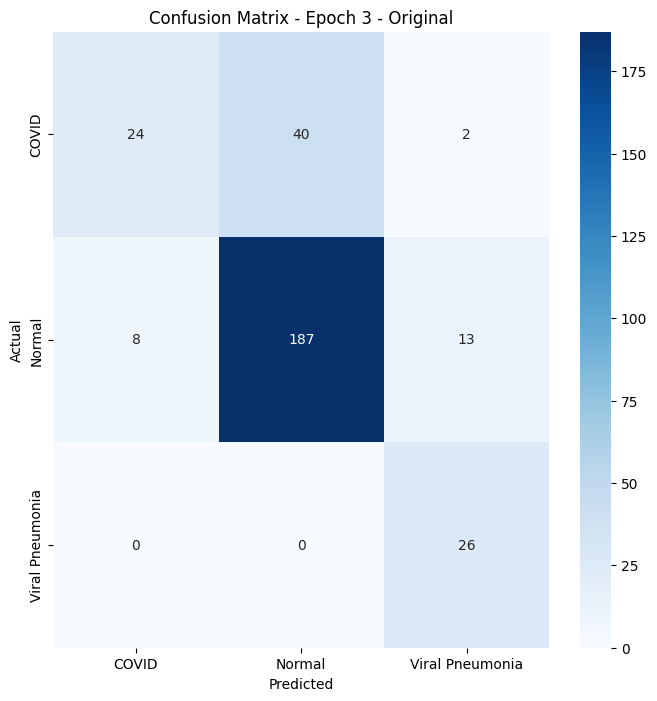

Epoch 4: Train Loss: 0.4524, Accuracy: 0.8142


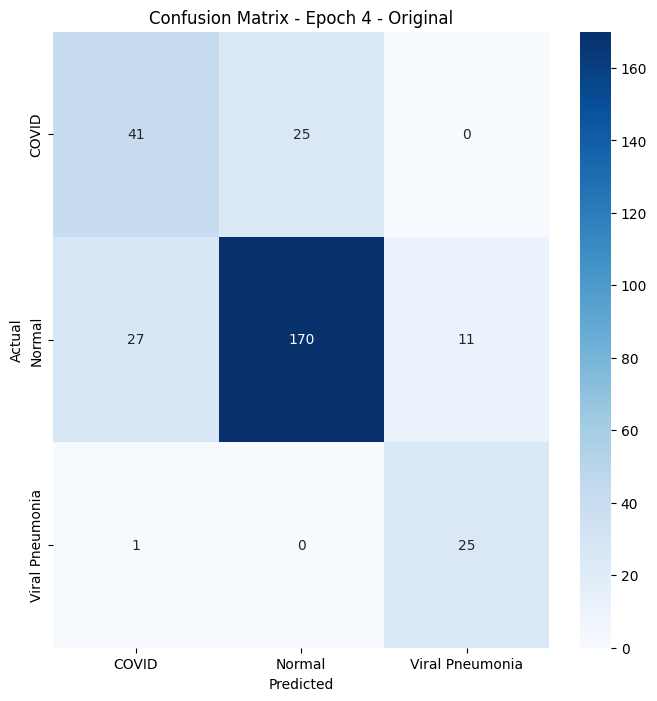

Epoch 5: Train Loss: 0.3631, Accuracy: 0.8467


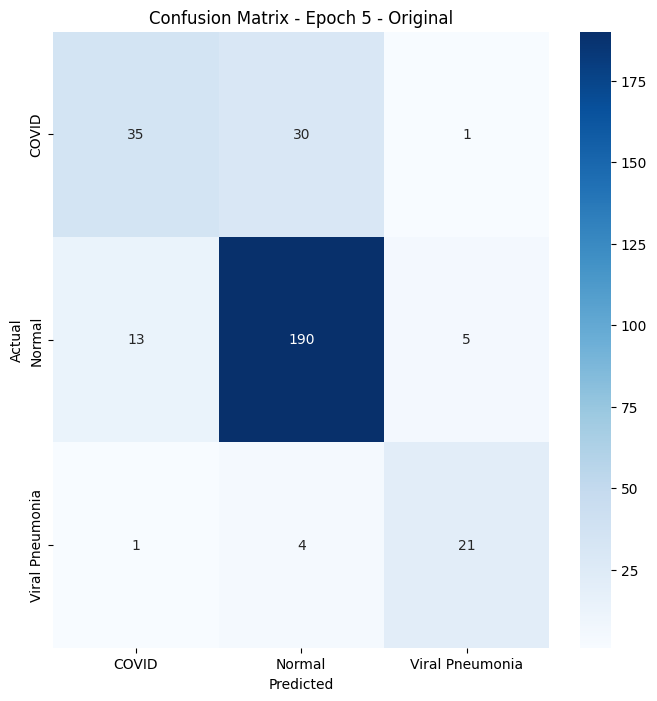

Epoch 6: Train Loss: 0.3017, Accuracy: 0.8783


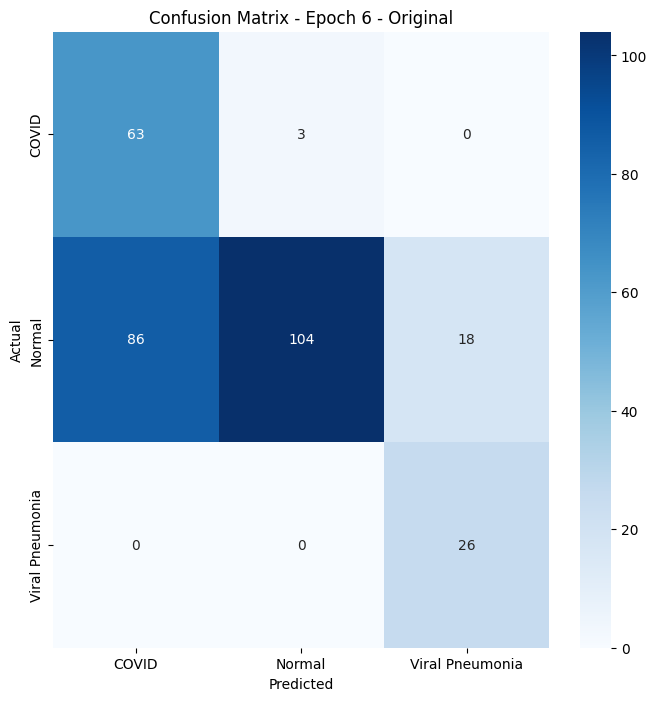

Epoch 7: Train Loss: 0.3084, Accuracy: 0.8692


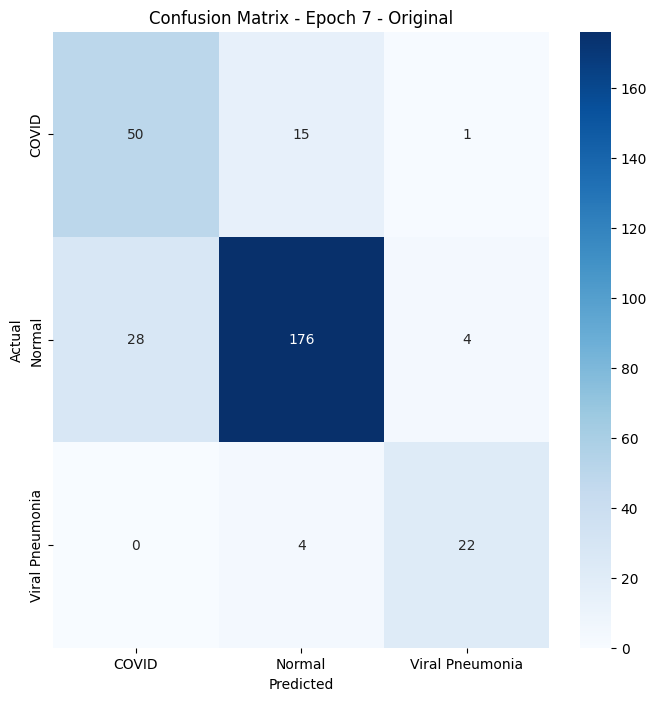

Epoch 8: Train Loss: 0.2478, Accuracy: 0.8867


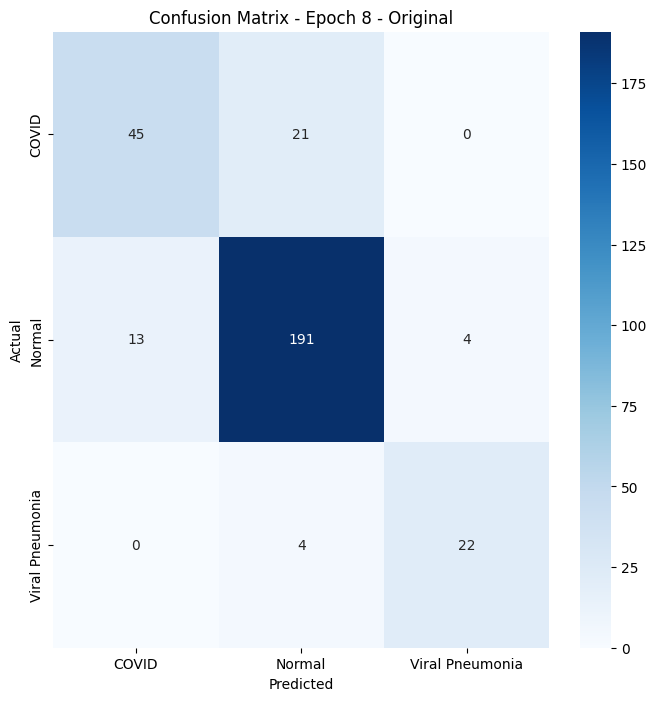

Epoch 9: Train Loss: 0.1787, Accuracy: 0.9342


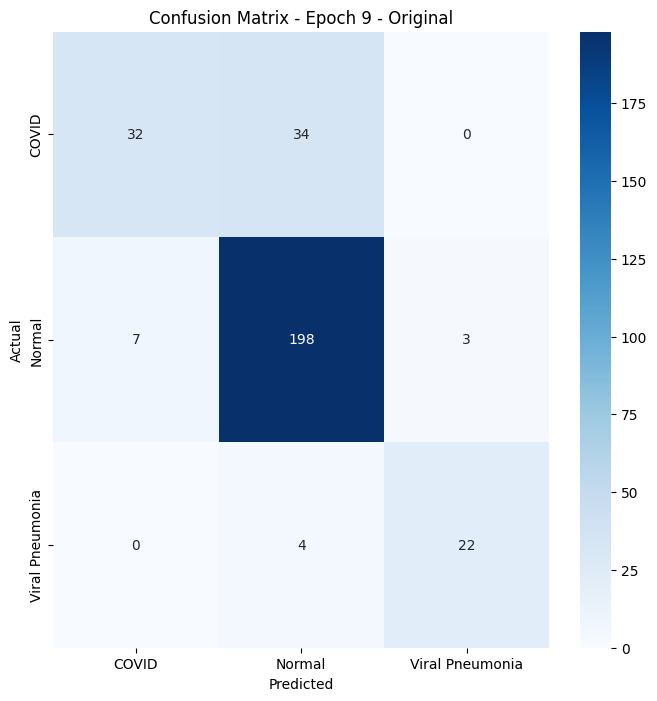

Epoch 10: Train Loss: 0.1746, Accuracy: 0.9342


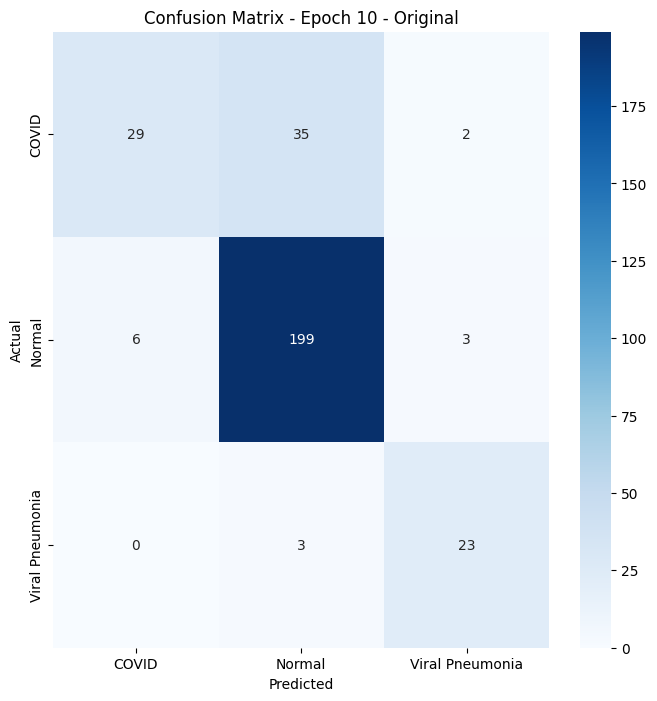

Epoch 11: Train Loss: 0.1232, Accuracy: 0.9558


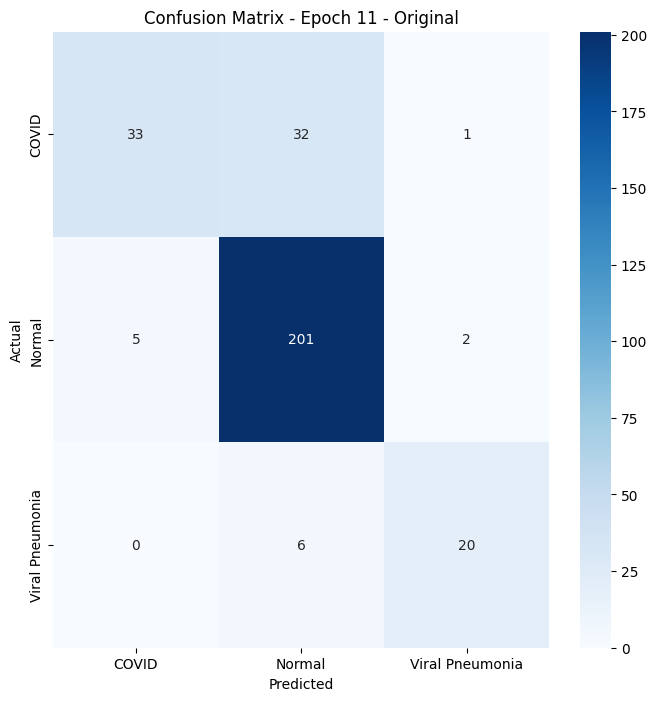

Epoch 12: Train Loss: 0.1181, Accuracy: 0.9567


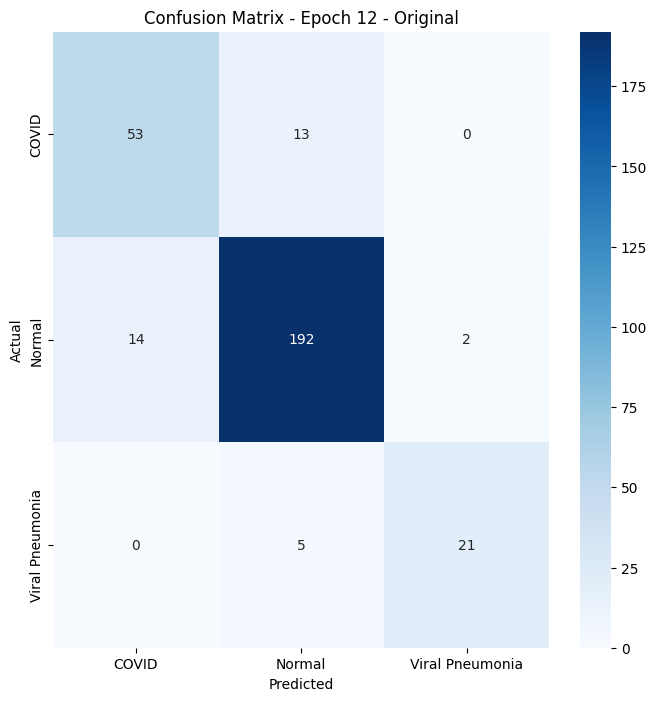

Epoch 13: Train Loss: 0.0757, Accuracy: 0.9775


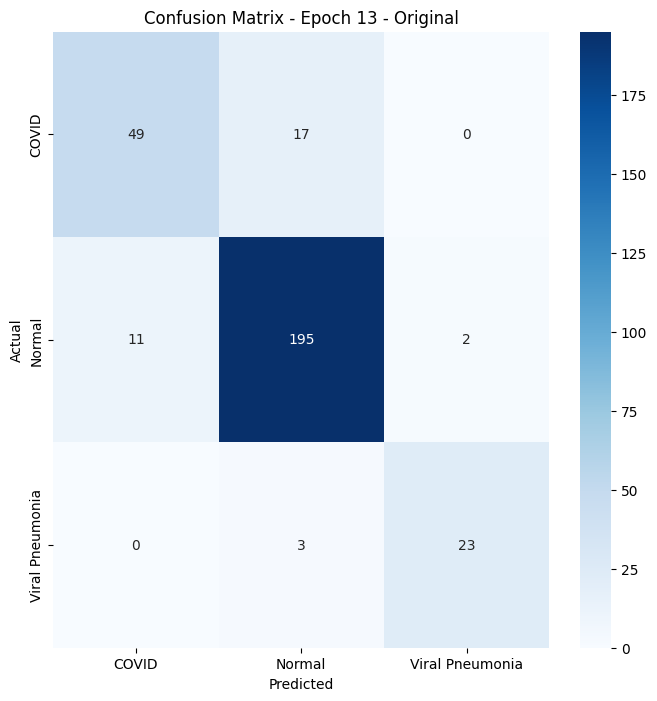

Epoch 14: Train Loss: 0.0642, Accuracy: 0.9792


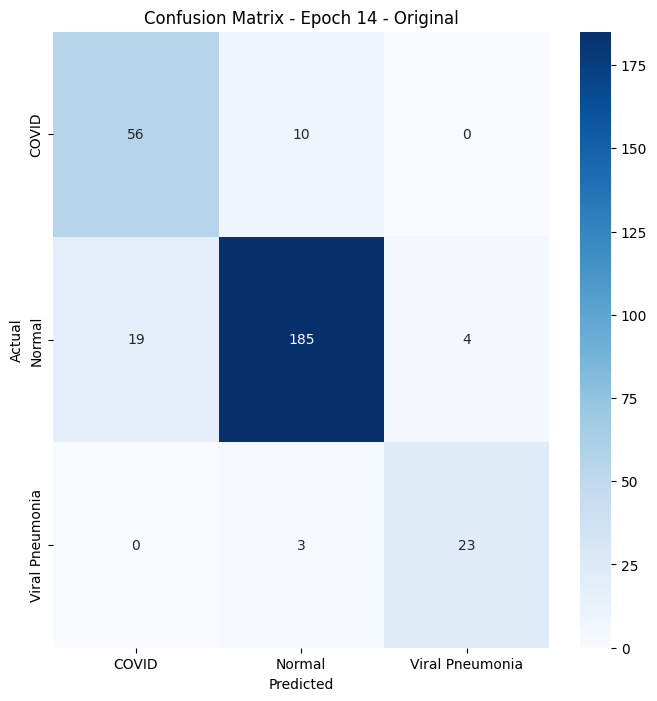

Epoch 15: Train Loss: 0.0341, Accuracy: 0.9908


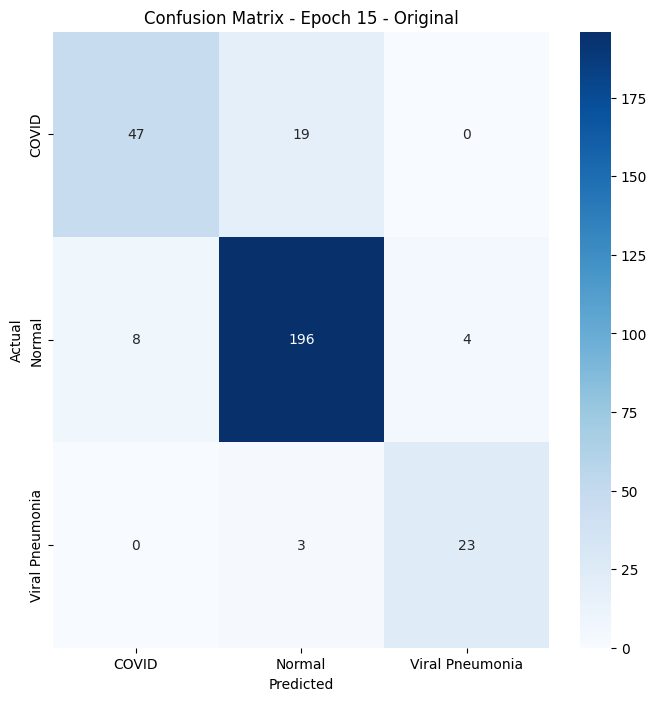

Epoch 16: Train Loss: 0.0323, Accuracy: 0.9917


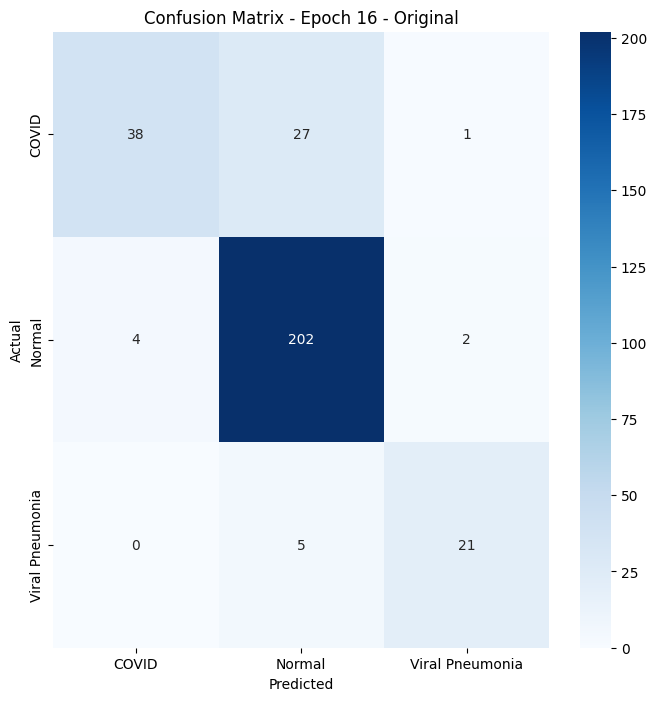

Epoch 17: Train Loss: 0.0389, Accuracy: 0.9858


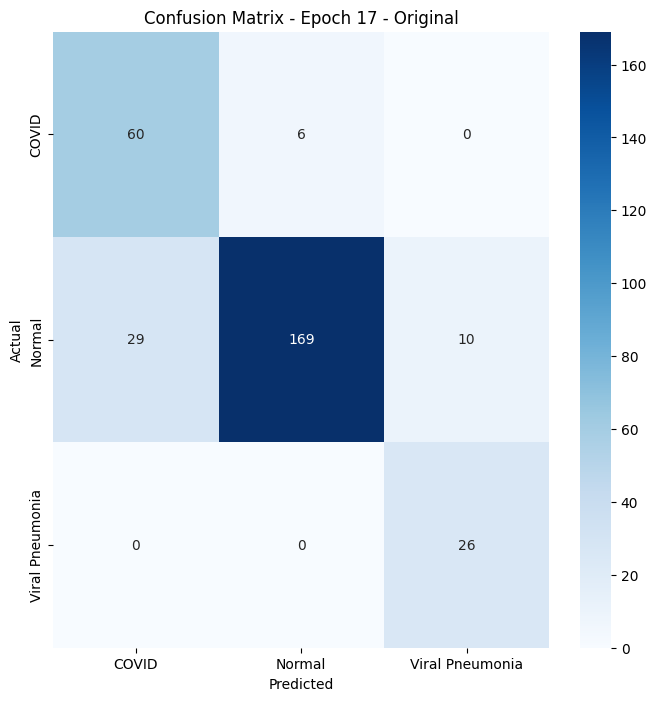

Epoch 18: Train Loss: 0.0697, Accuracy: 0.9725


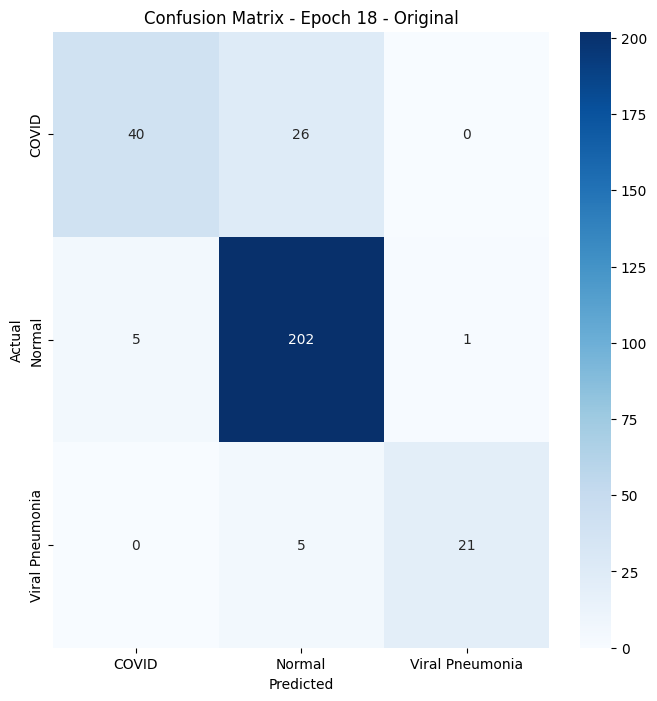

Epoch 19: Train Loss: 0.0261, Accuracy: 0.9942


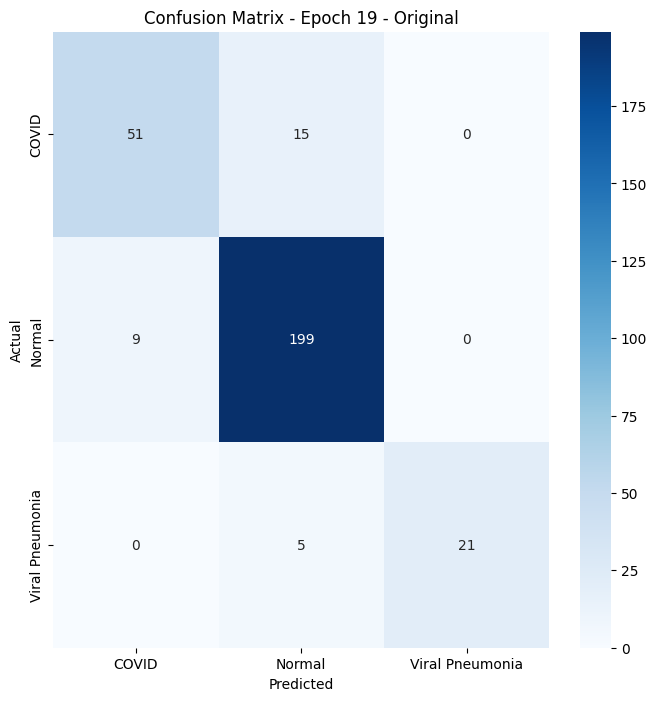

Epoch 20: Train Loss: 0.0109, Accuracy: 0.9975


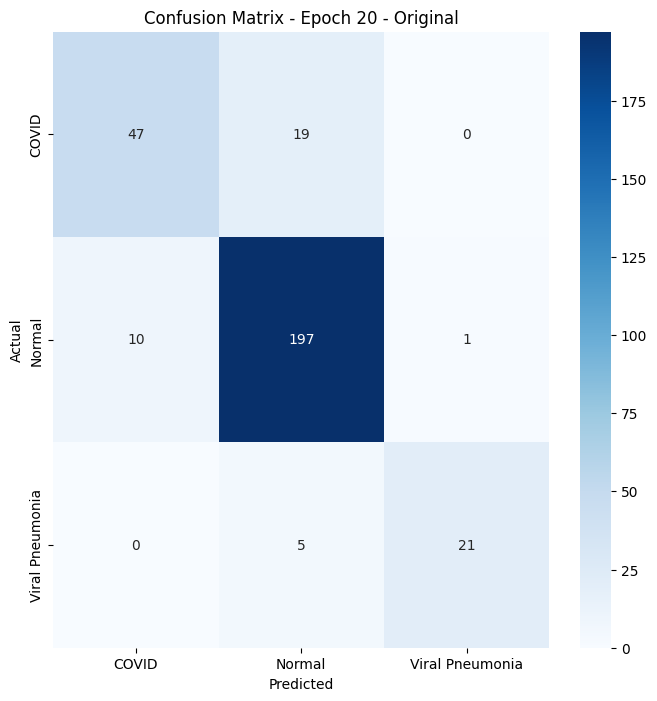

In [11]:
class_names = original_dataset.classes

orig_metrics = train_and_evaluate(original_train_loader, original_test_loader, "Original", class_names)


Training on LowRes dataset:
Epoch 1: Train Loss: 1.0263, Accuracy: 0.6317


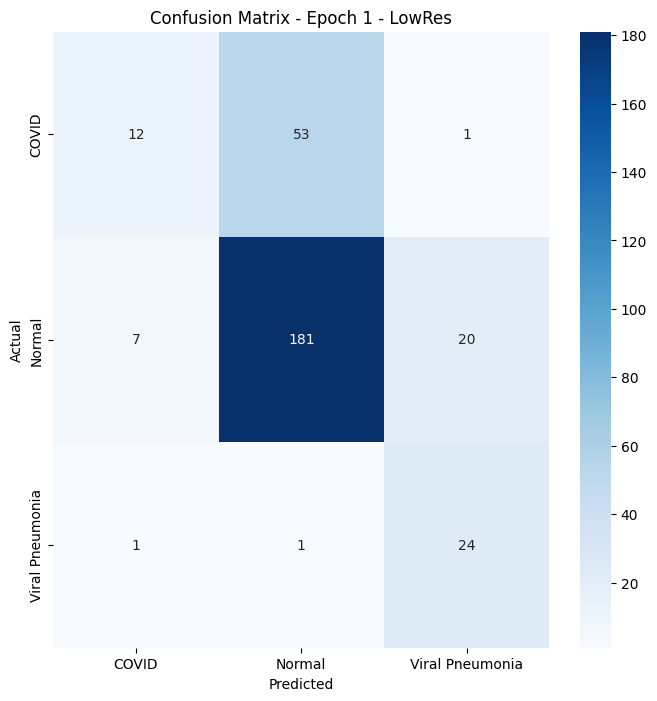

Epoch 2: Train Loss: 0.5268, Accuracy: 0.7533


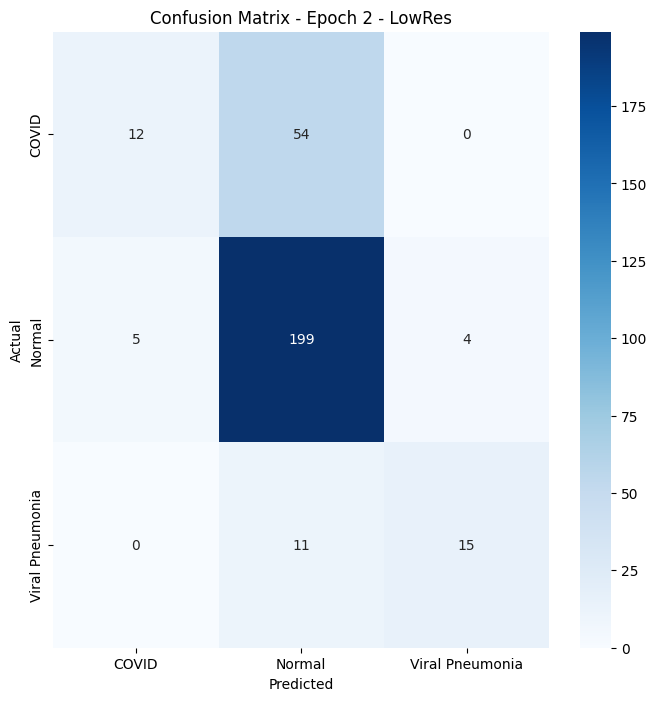

Epoch 3: Train Loss: 0.4419, Accuracy: 0.8008


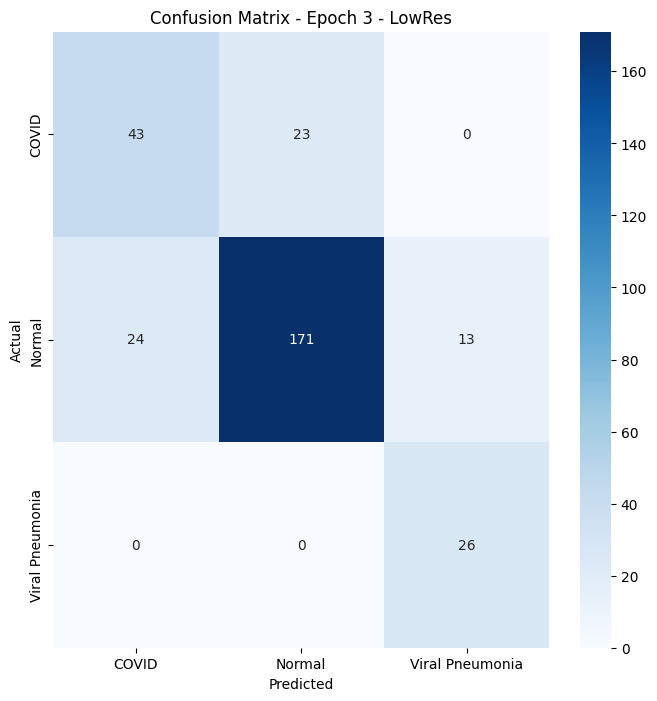

Epoch 4: Train Loss: 0.3880, Accuracy: 0.8208


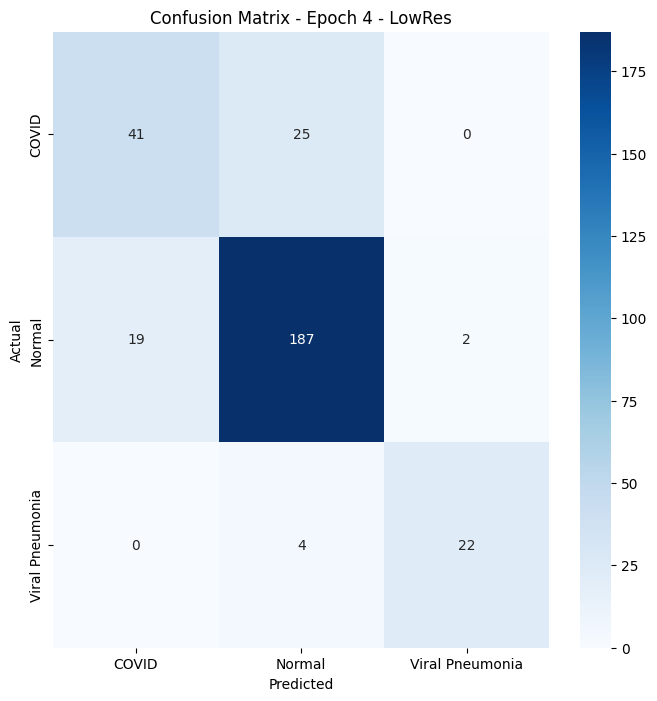

Epoch 5: Train Loss: 0.3389, Accuracy: 0.8475


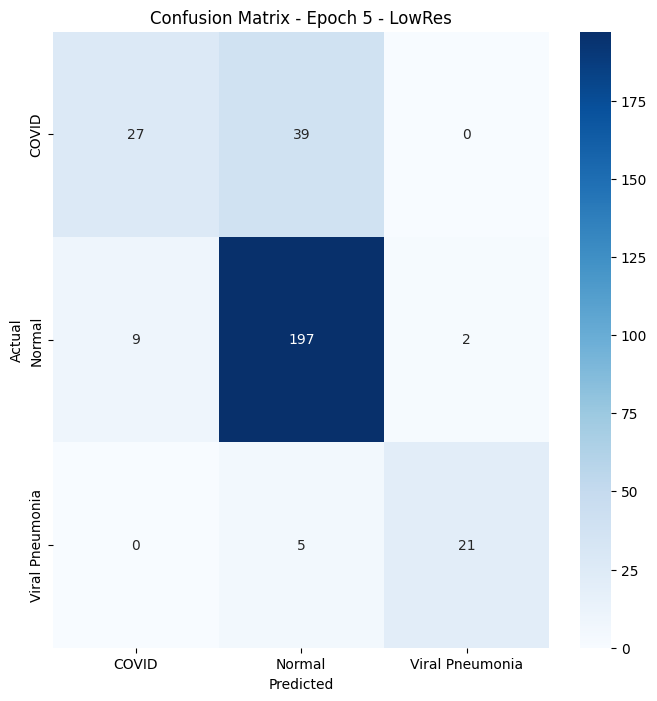

Epoch 6: Train Loss: 0.3151, Accuracy: 0.8608


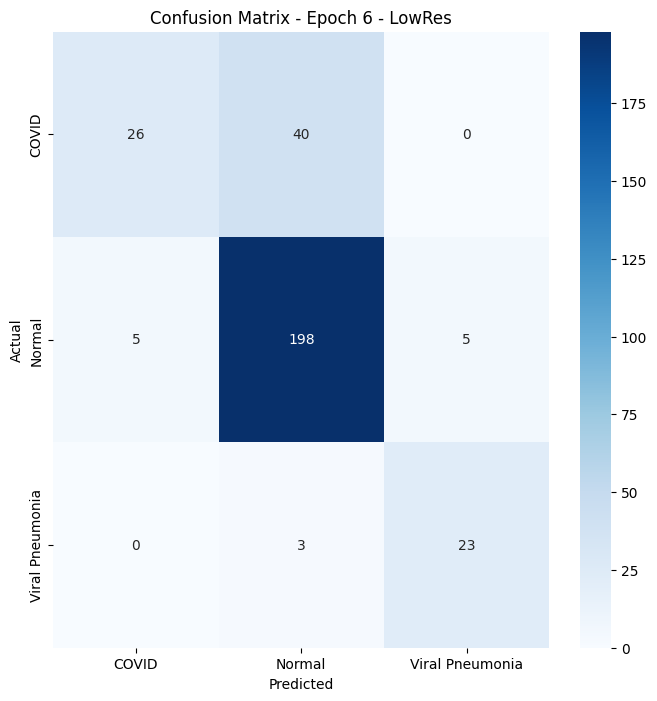

Epoch 7: Train Loss: 0.2588, Accuracy: 0.8950


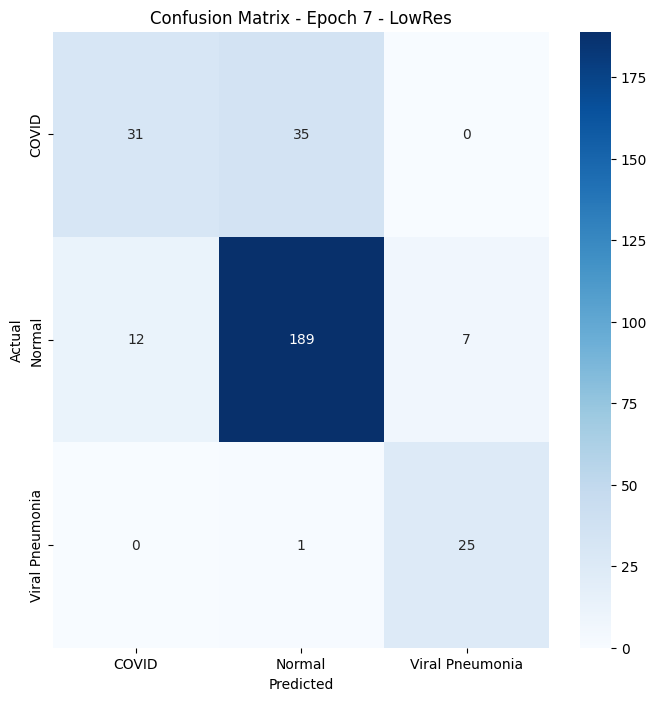

Epoch 8: Train Loss: 0.2250, Accuracy: 0.9075


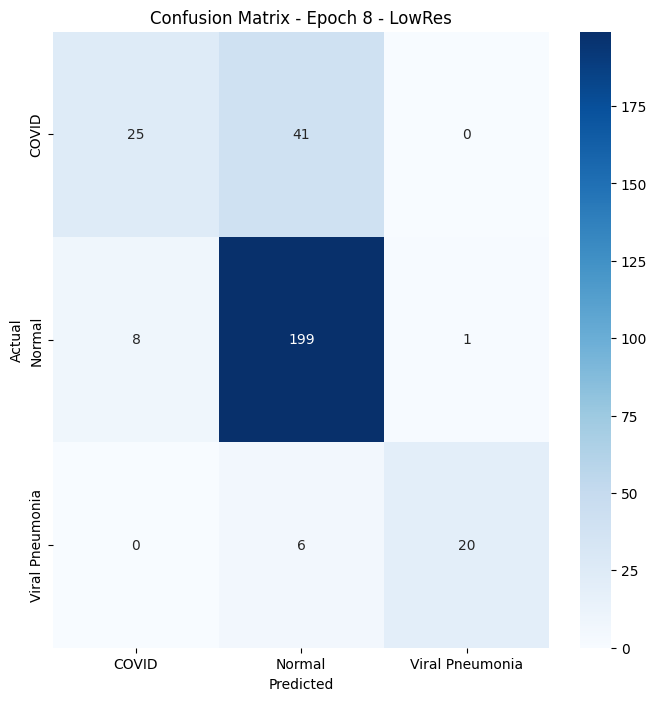

Epoch 9: Train Loss: 0.1905, Accuracy: 0.9225


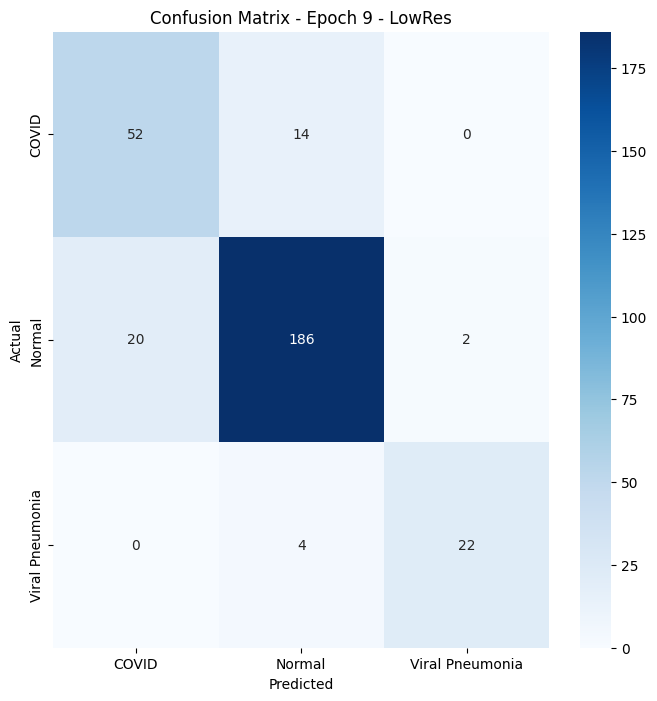

Epoch 10: Train Loss: 0.1781, Accuracy: 0.9308


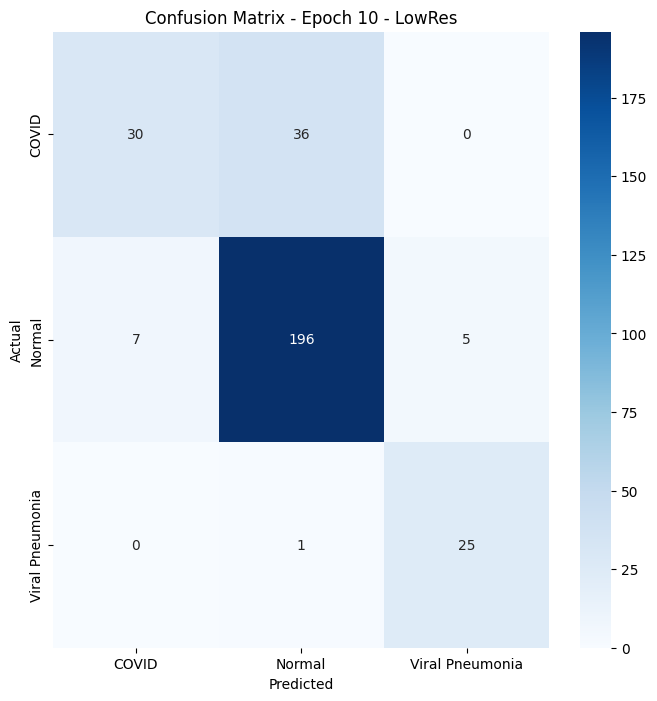

Epoch 11: Train Loss: 0.1839, Accuracy: 0.9233


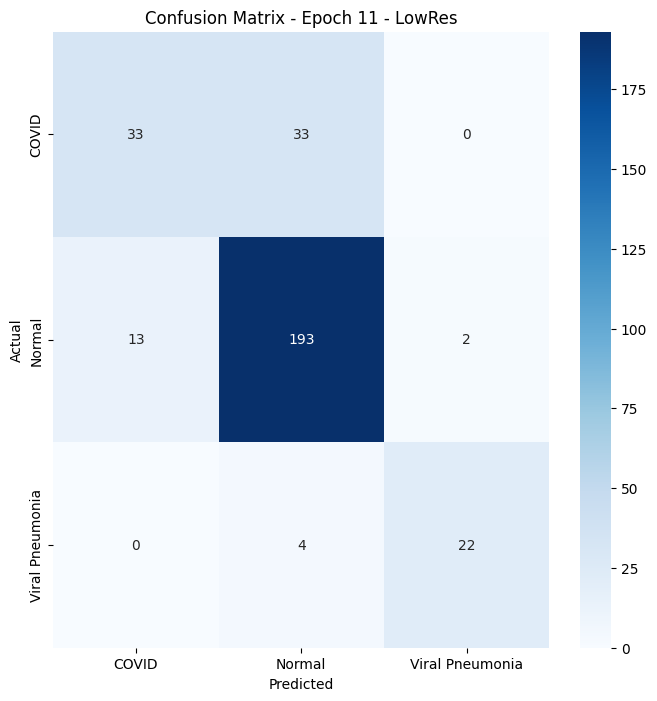

Epoch 12: Train Loss: 0.1256, Accuracy: 0.9417


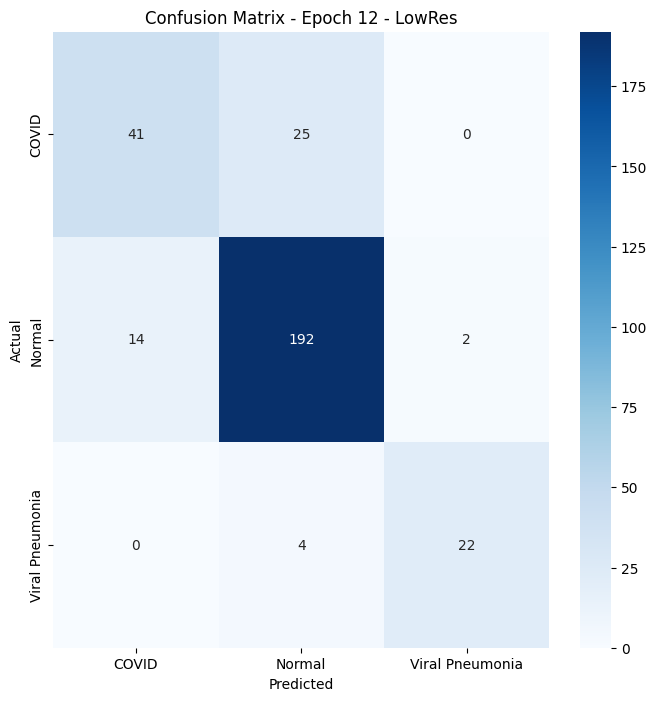

Epoch 13: Train Loss: 0.1062, Accuracy: 0.9667


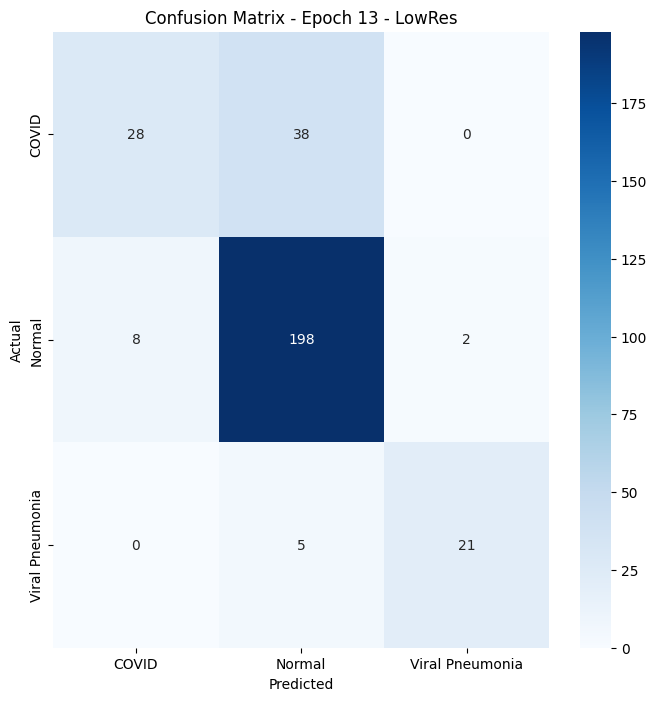

Epoch 14: Train Loss: 0.0772, Accuracy: 0.9708


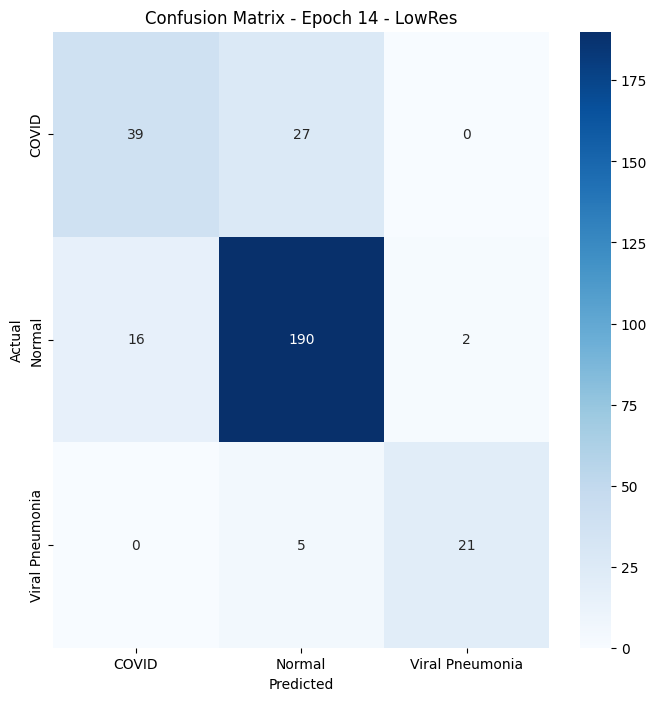

Epoch 15: Train Loss: 0.0556, Accuracy: 0.9850


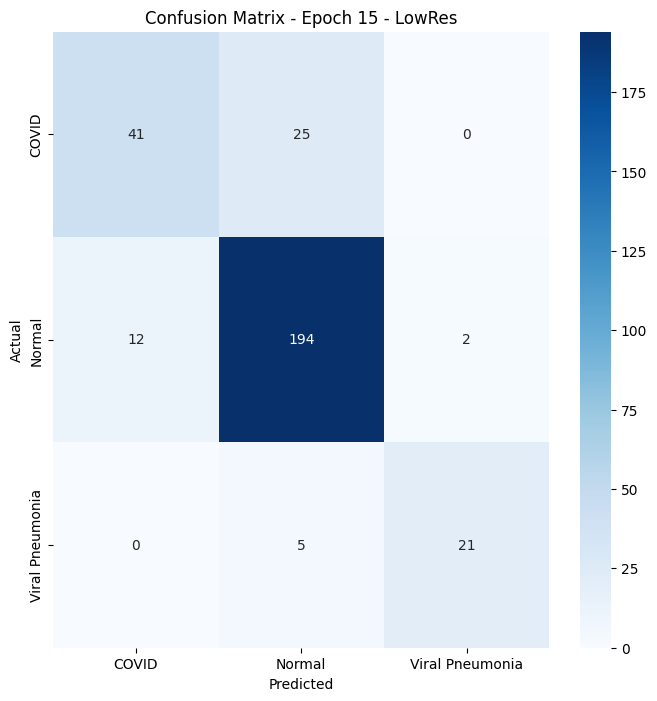

Epoch 16: Train Loss: 0.0939, Accuracy: 0.9675


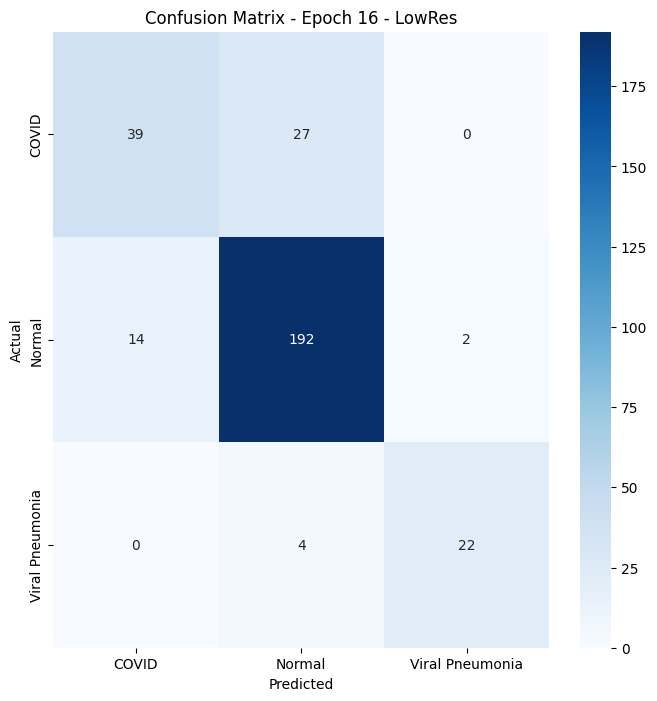

Epoch 17: Train Loss: 0.0753, Accuracy: 0.9683


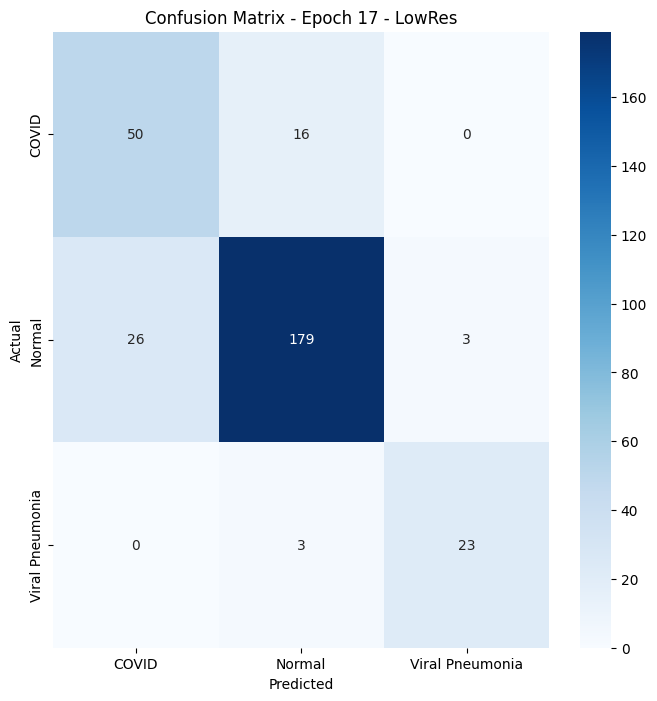

Epoch 18: Train Loss: 0.0730, Accuracy: 0.9733


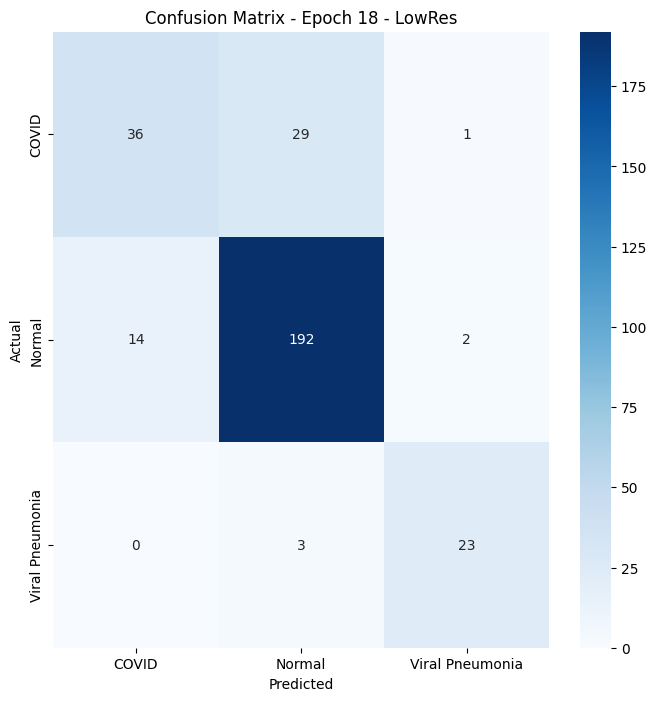

Epoch 19: Train Loss: 0.0563, Accuracy: 0.9867


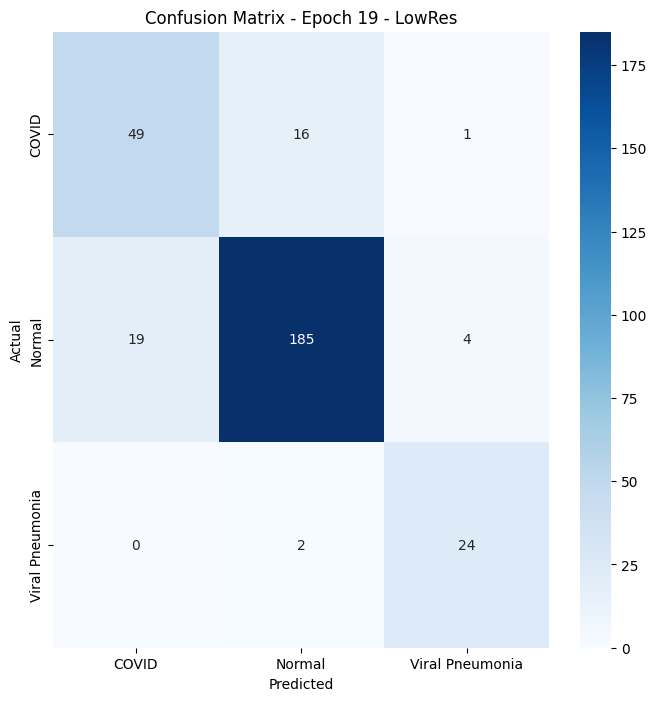

Epoch 20: Train Loss: 0.0339, Accuracy: 0.9908


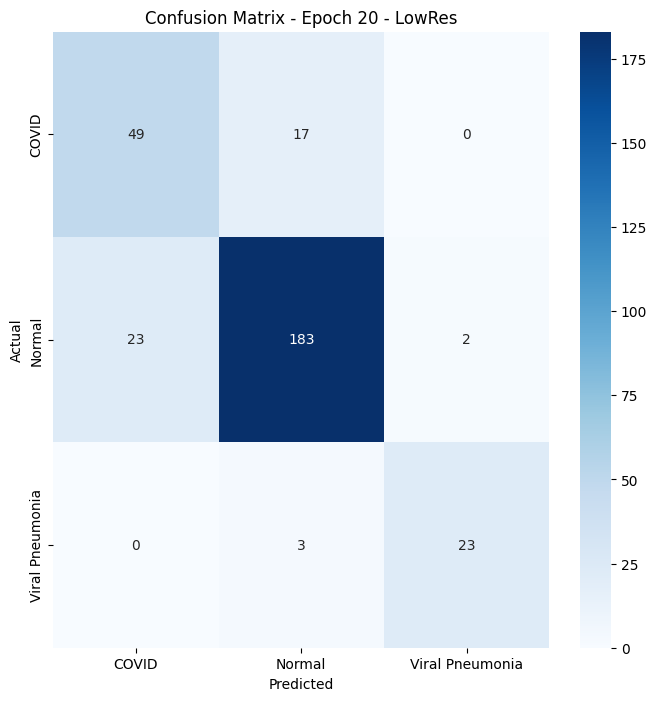

In [12]:
lowres_metrics = train_and_evaluate(lowres_train_loader, lowres_test_loader, "LowRes", class_names)


Training on Enhanced LowRes dataset:
Epoch 1: Train Loss: 0.7339, Accuracy: 0.6950


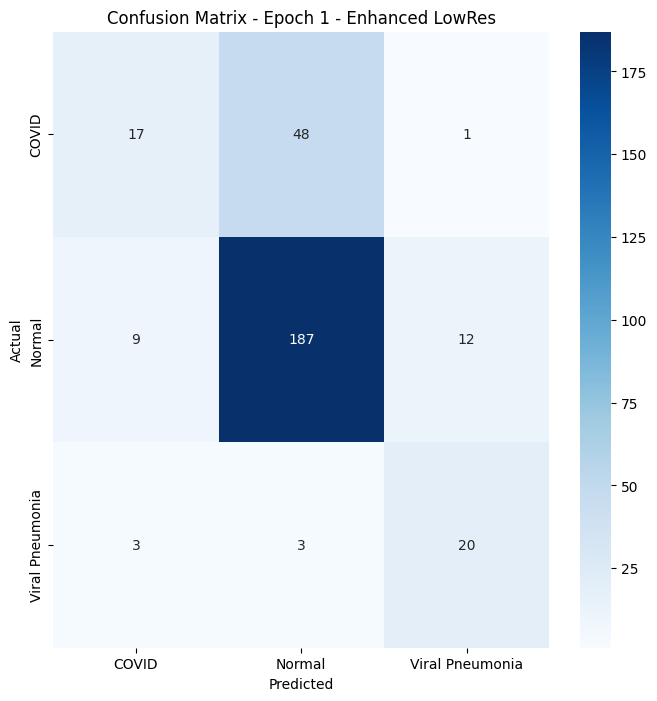

Epoch 2: Train Loss: 0.4903, Accuracy: 0.7675


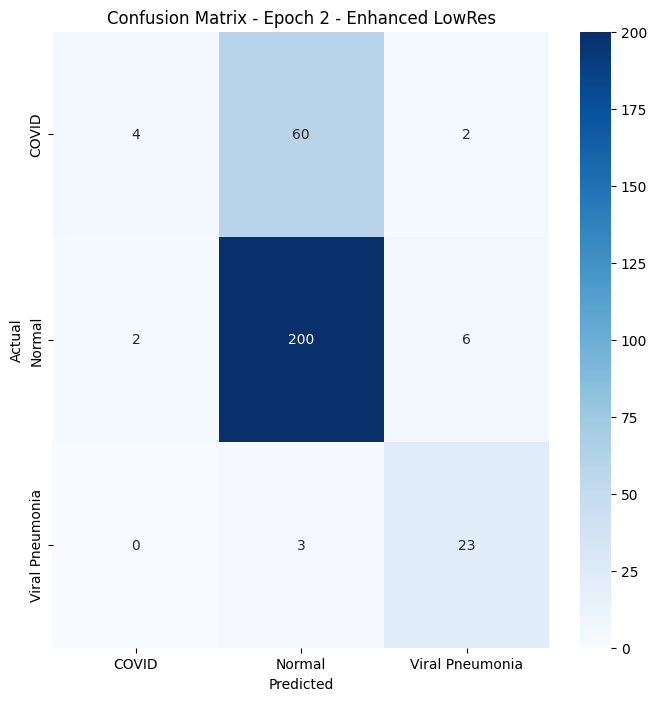

Epoch 3: Train Loss: 0.4776, Accuracy: 0.7833


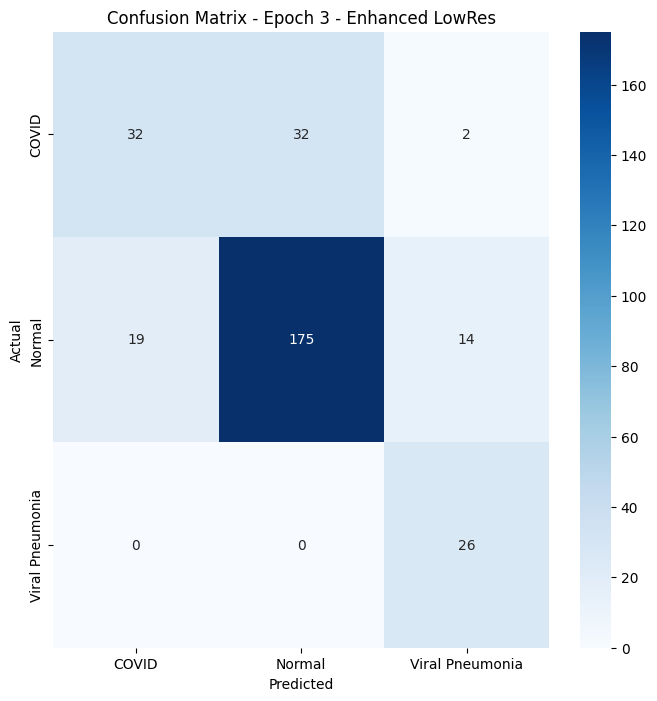

Epoch 4: Train Loss: 0.3603, Accuracy: 0.8342


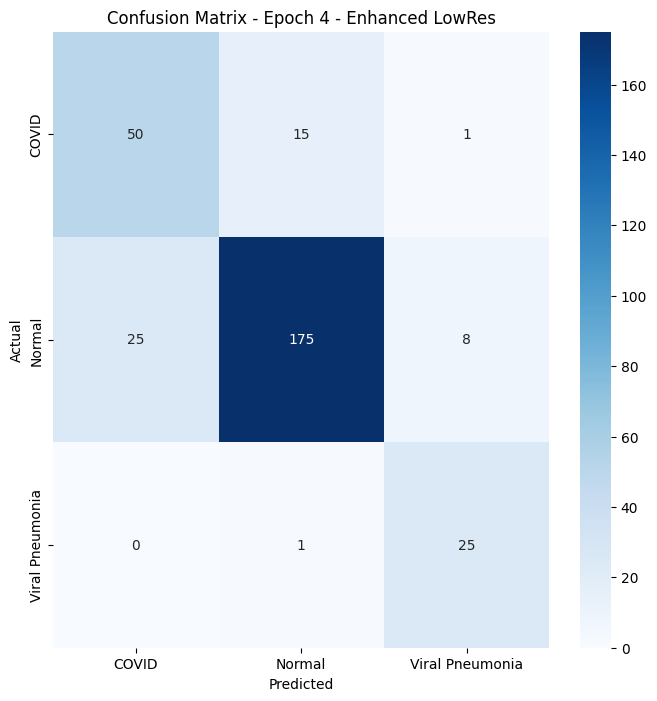

Epoch 5: Train Loss: 0.2966, Accuracy: 0.8733


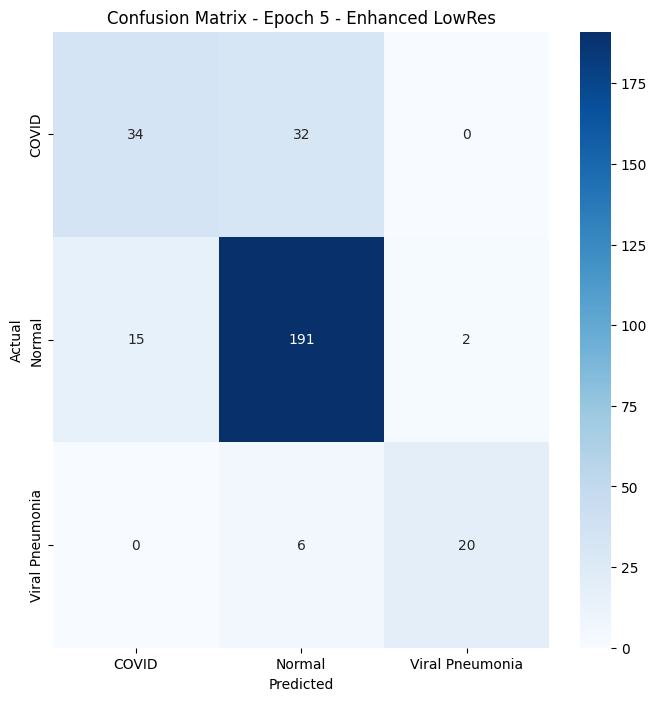

Epoch 6: Train Loss: 0.2632, Accuracy: 0.8933


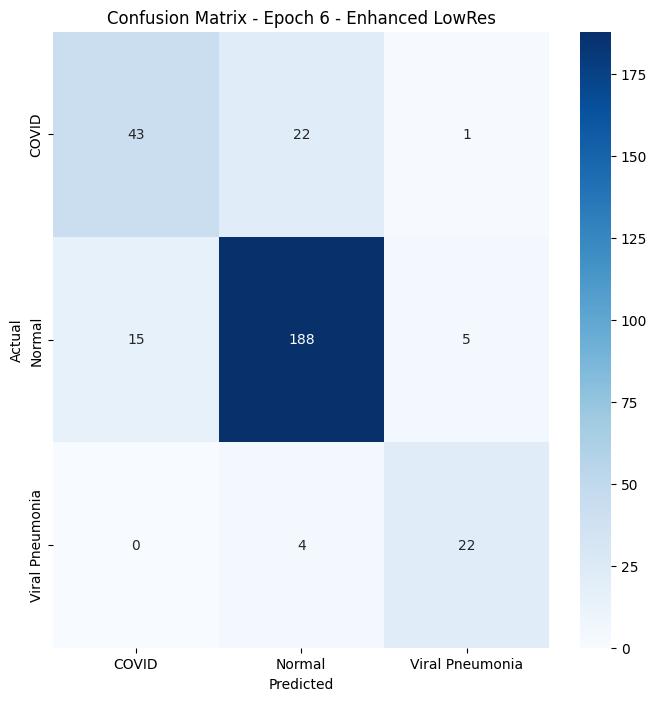

Epoch 7: Train Loss: 0.1694, Accuracy: 0.9383


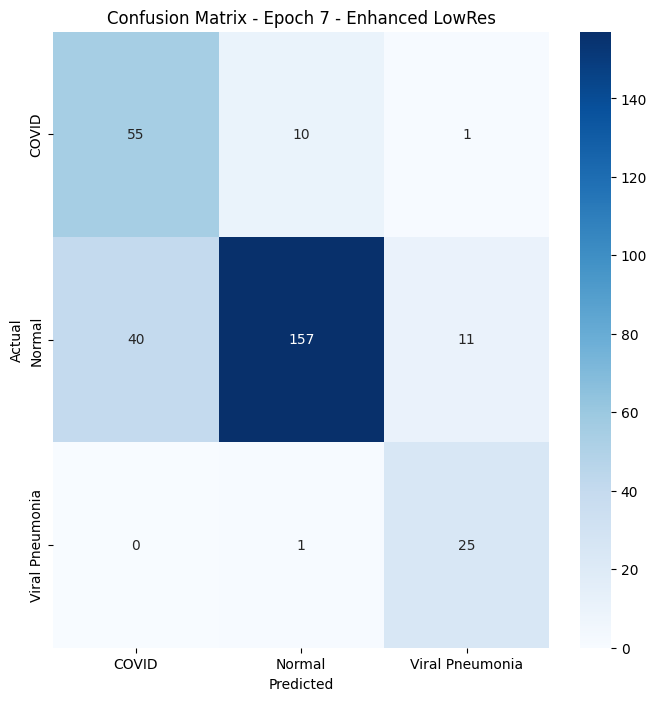

Epoch 8: Train Loss: 0.1429, Accuracy: 0.9492


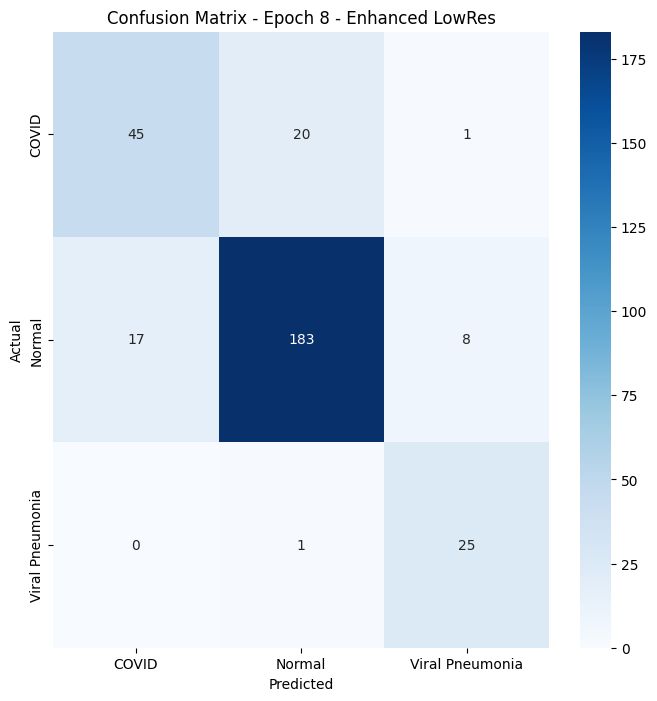

Epoch 9: Train Loss: 0.0978, Accuracy: 0.9658


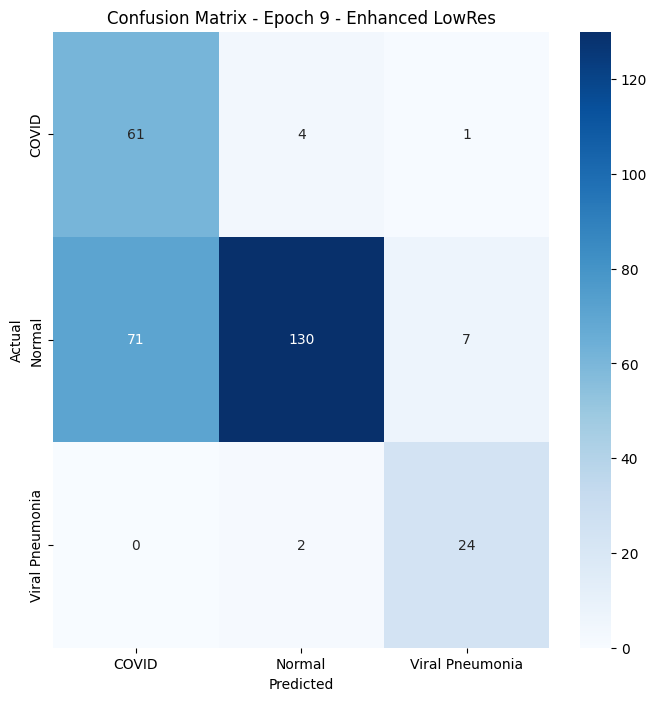

Epoch 10: Train Loss: 0.1725, Accuracy: 0.9242


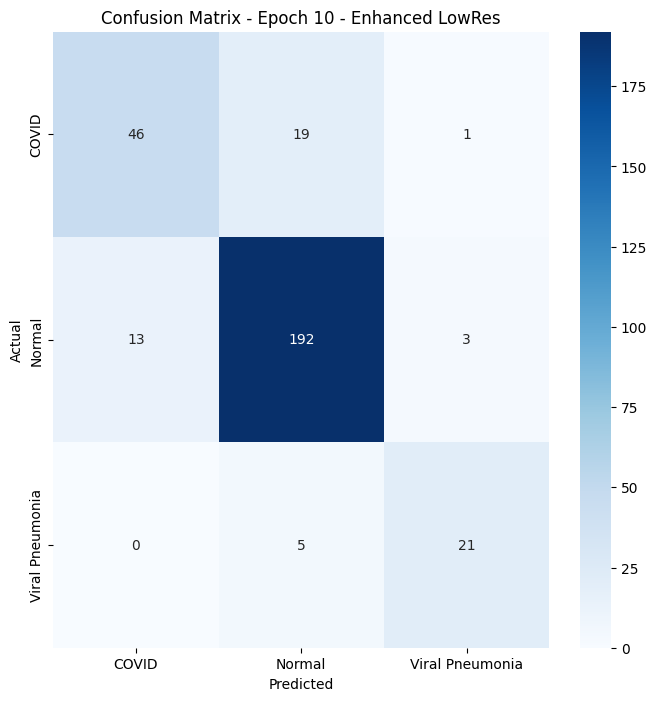

Epoch 11: Train Loss: 0.0869, Accuracy: 0.9683


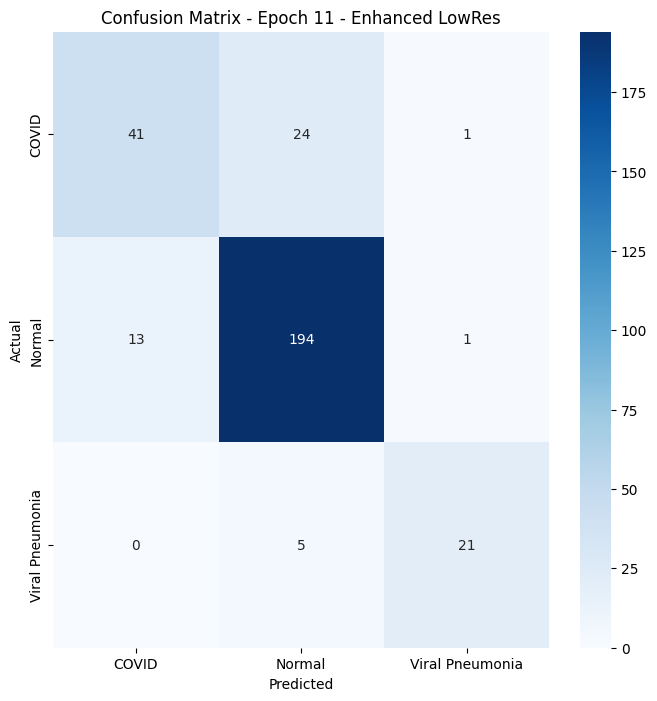

Epoch 12: Train Loss: 0.0350, Accuracy: 0.9942


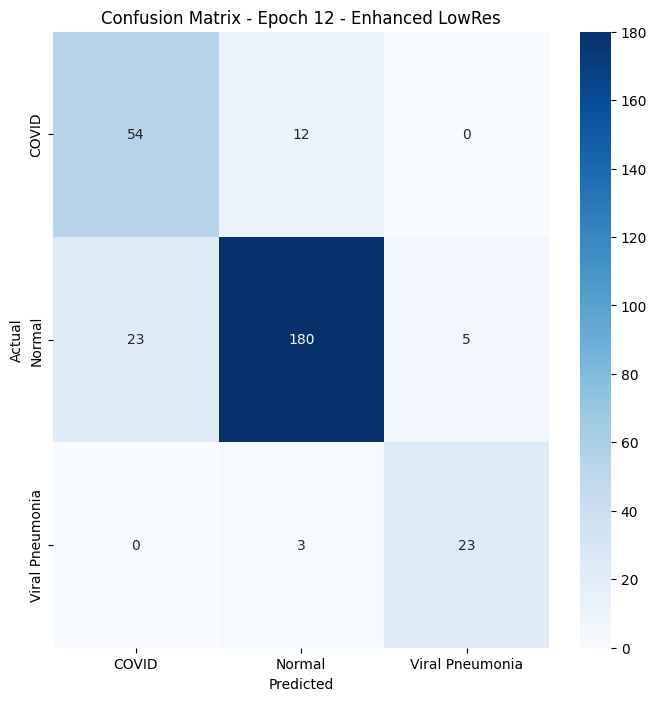

Epoch 13: Train Loss: 0.0318, Accuracy: 0.9883


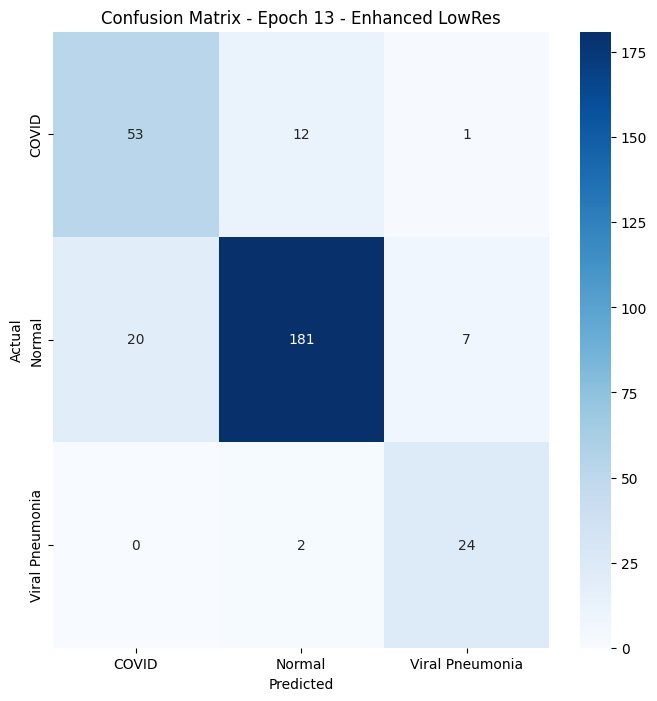

Epoch 14: Train Loss: 0.0242, Accuracy: 0.9908


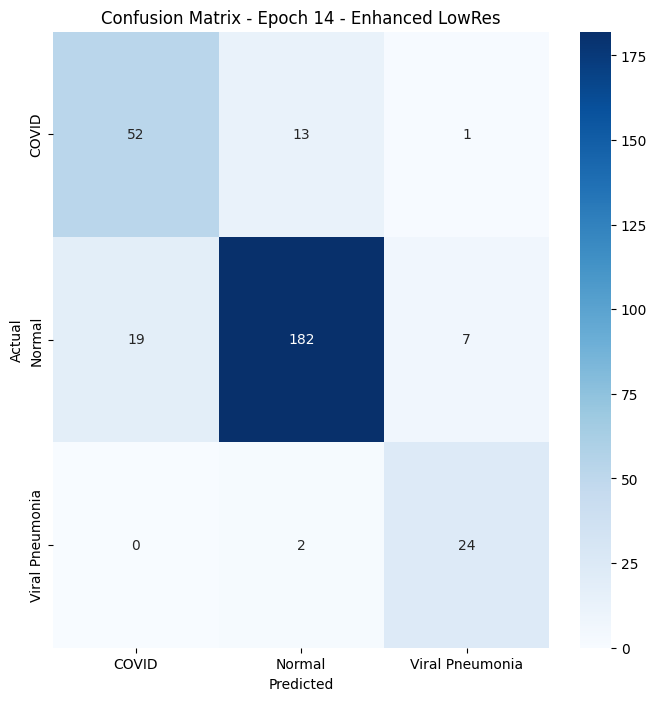

Epoch 15: Train Loss: 0.0101, Accuracy: 0.9983


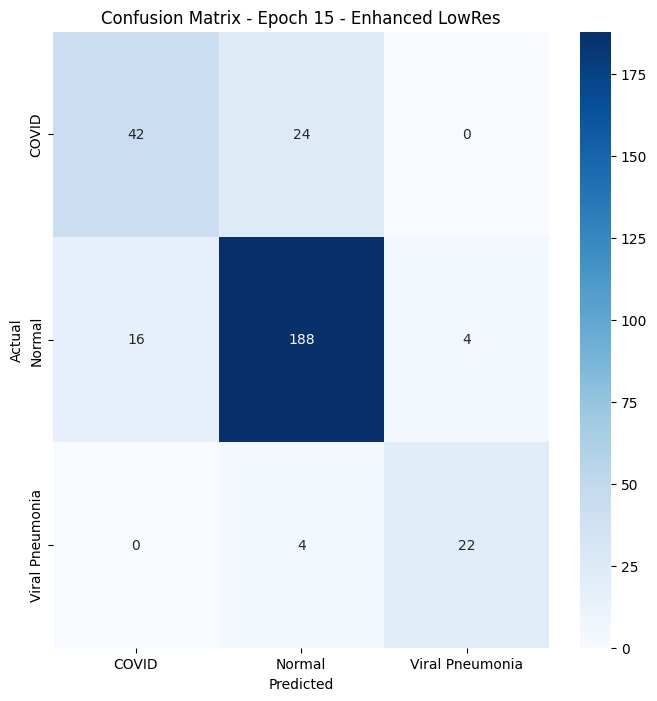

Epoch 16: Train Loss: 0.0042, Accuracy: 1.0000


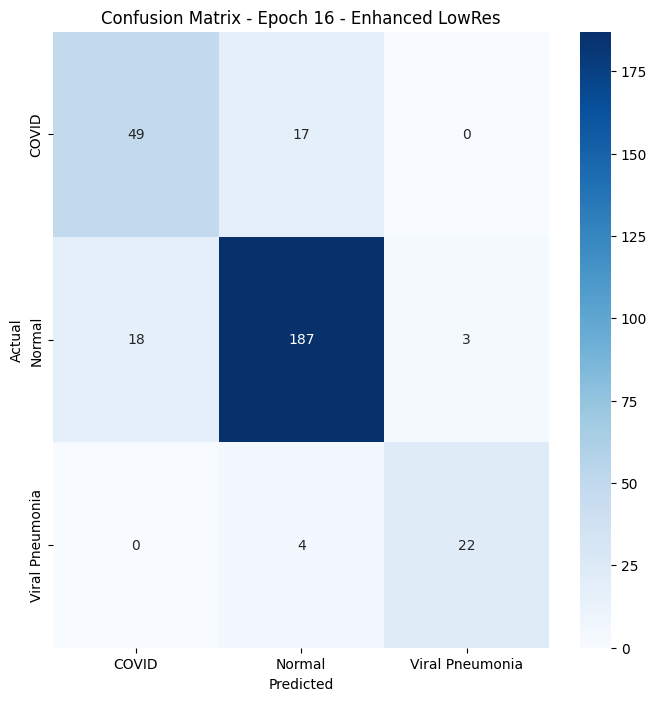

Epoch 17: Train Loss: 0.0028, Accuracy: 1.0000


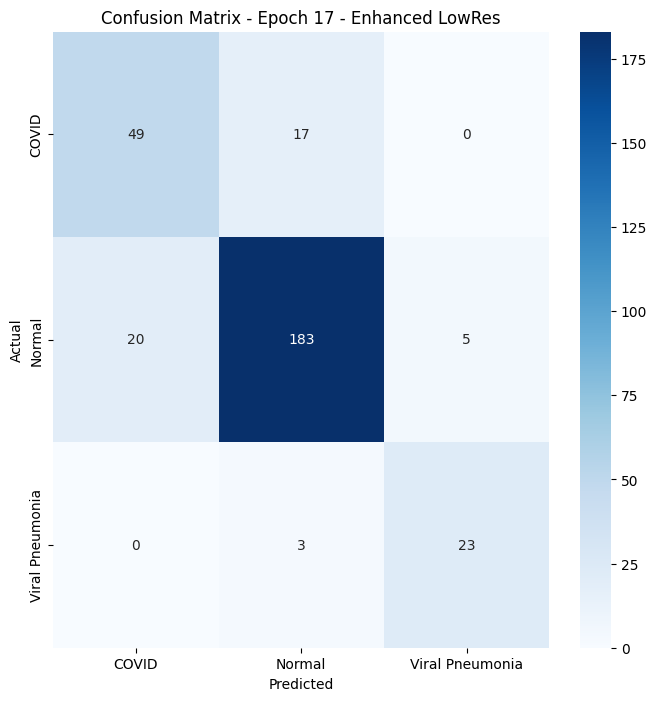

Epoch 18: Train Loss: 0.0020, Accuracy: 1.0000


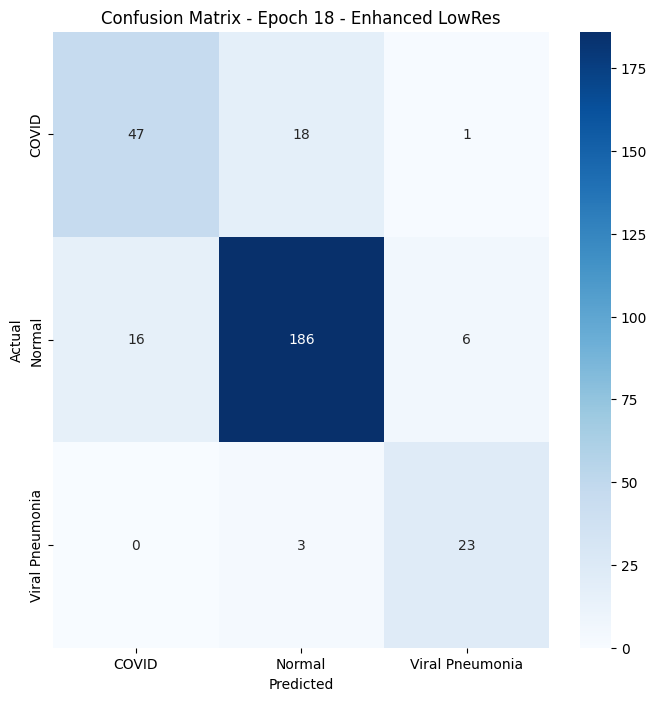

Epoch 19: Train Loss: 0.0016, Accuracy: 1.0000


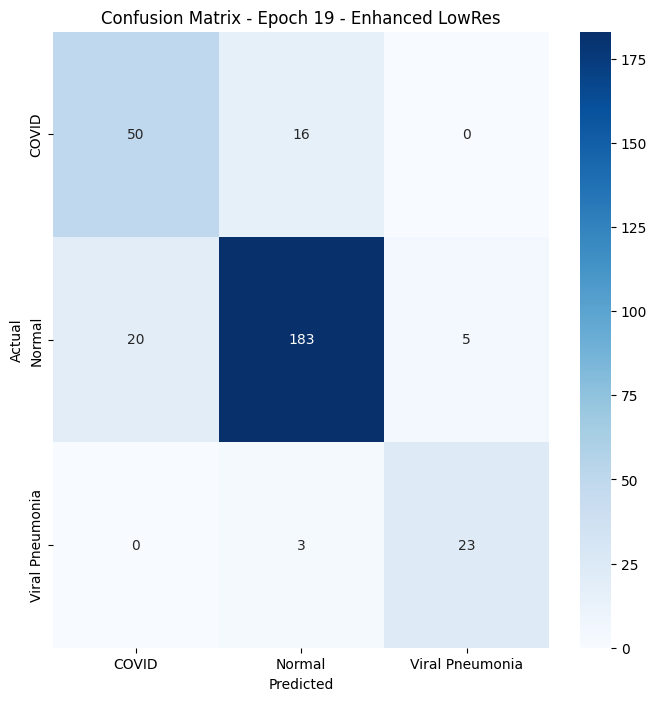

Epoch 20: Train Loss: 0.0013, Accuracy: 1.0000


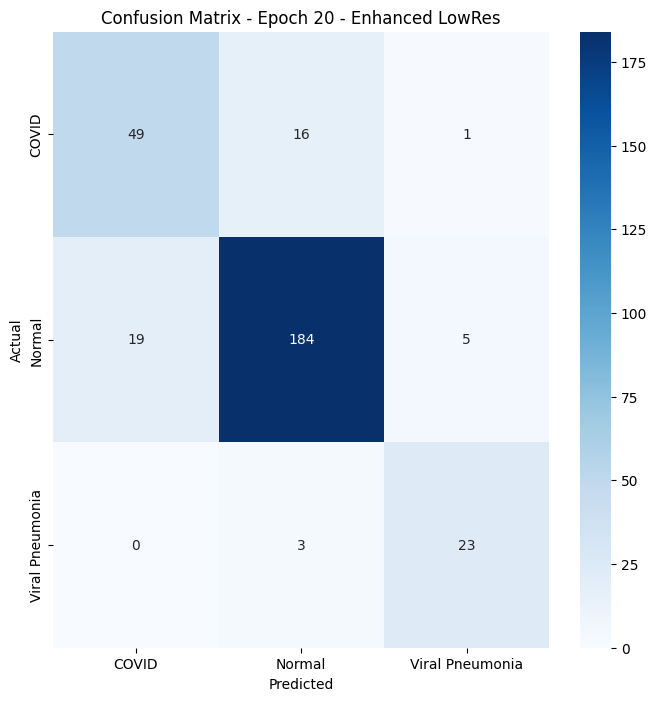

In [13]:
enhanced_lowres_metrics = train_and_evaluate(enhanced_train_lowres_loader, enhanced_test_lowres_loader, "Enhanced LowRes", class_names)


Training on Enhanced Original dataset:
Epoch 1: Train Loss: 1.0067, Accuracy: 0.6675


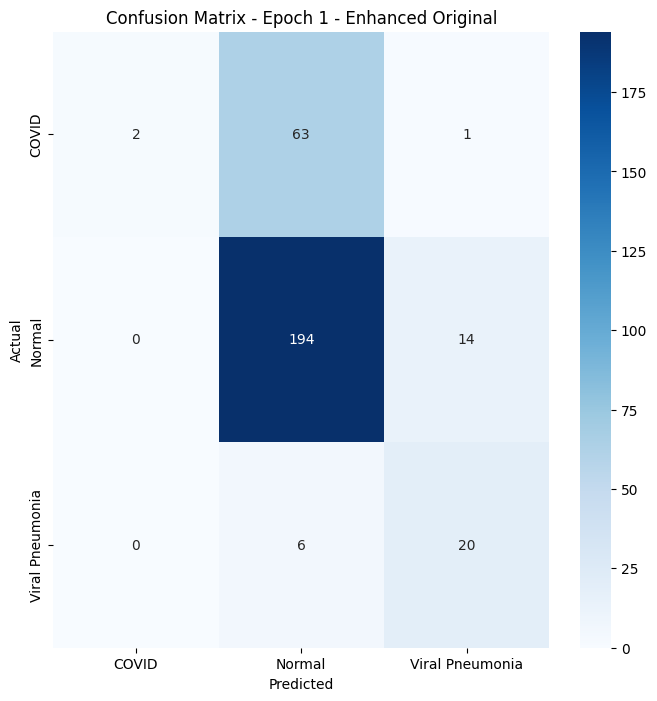

Epoch 2: Train Loss: 0.5283, Accuracy: 0.7650


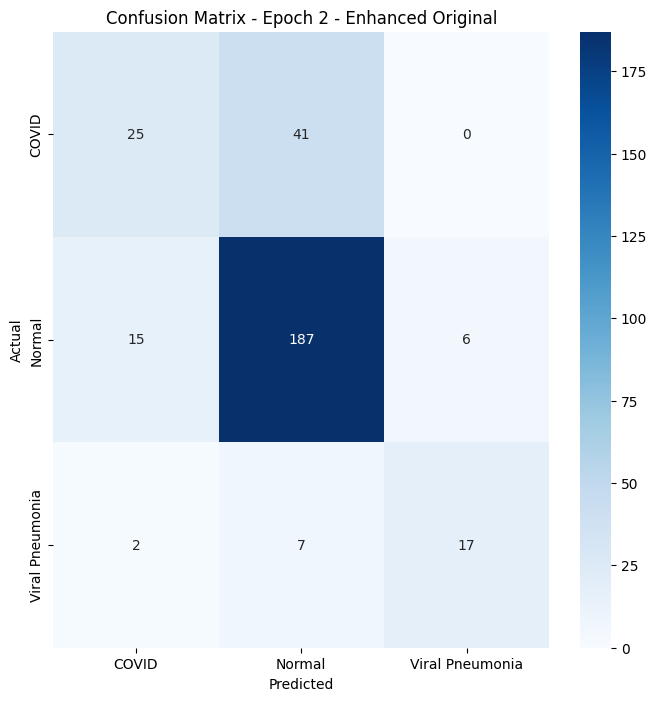

Epoch 3: Train Loss: 0.4676, Accuracy: 0.8000


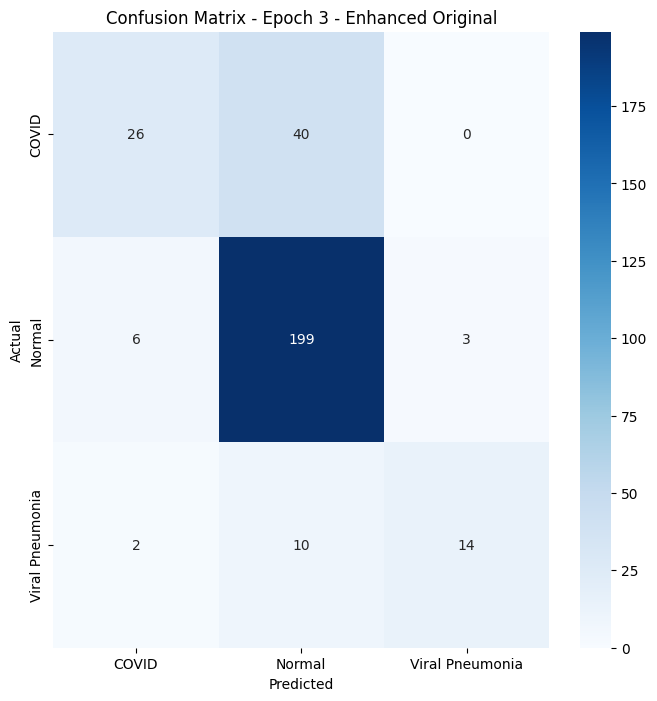

Epoch 4: Train Loss: 0.3583, Accuracy: 0.8375


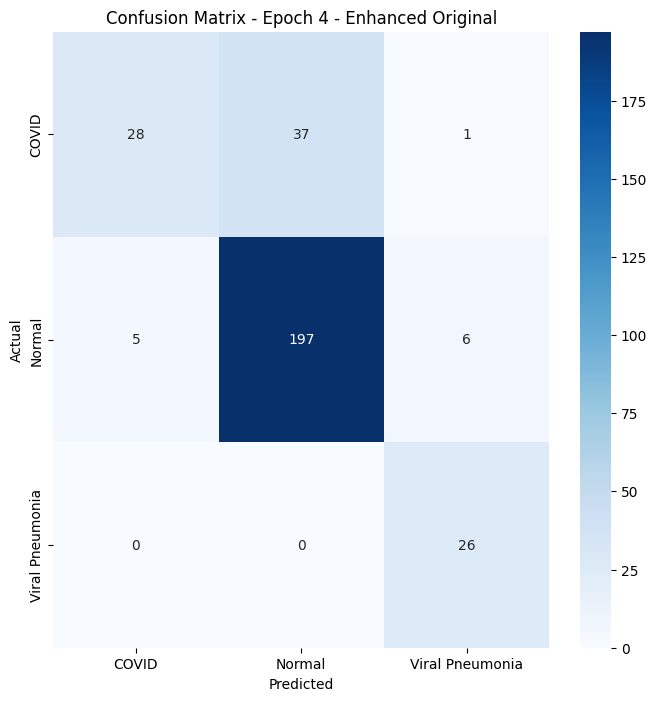

Epoch 5: Train Loss: 0.2840, Accuracy: 0.8833


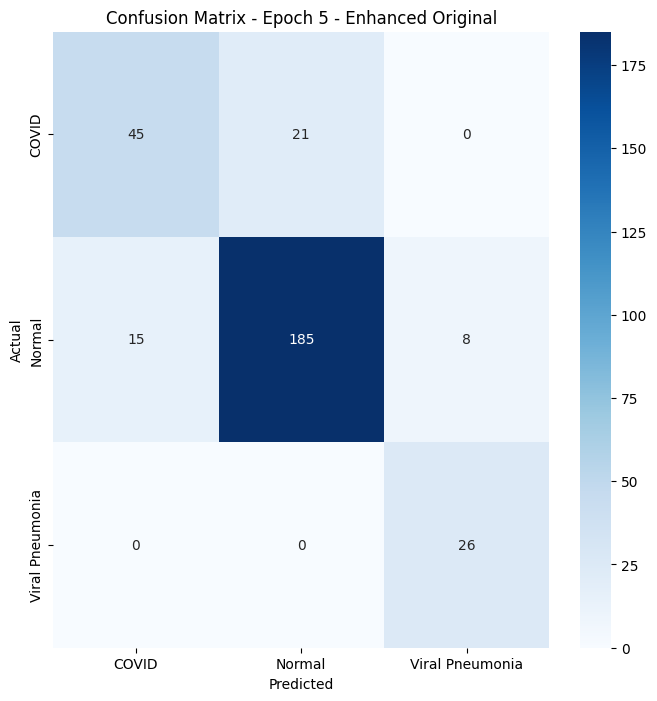

Epoch 6: Train Loss: 0.2196, Accuracy: 0.9125


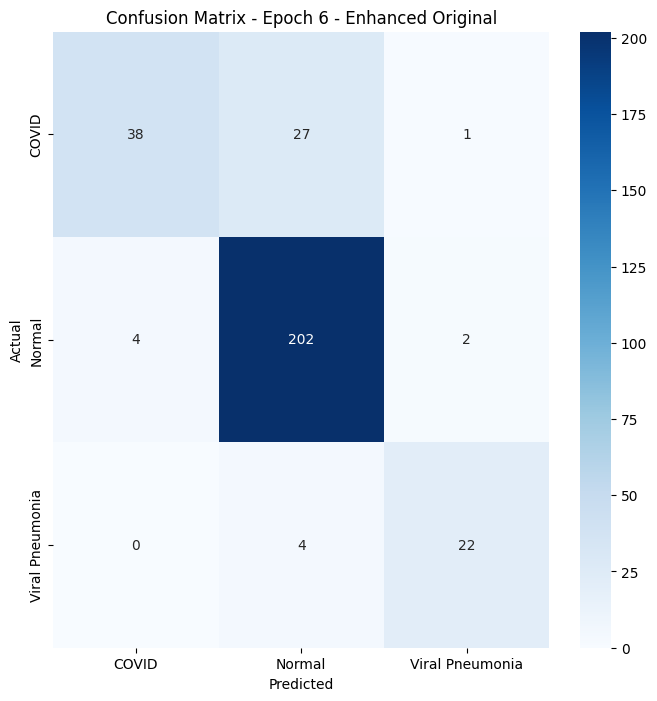

Epoch 7: Train Loss: 0.1550, Accuracy: 0.9467


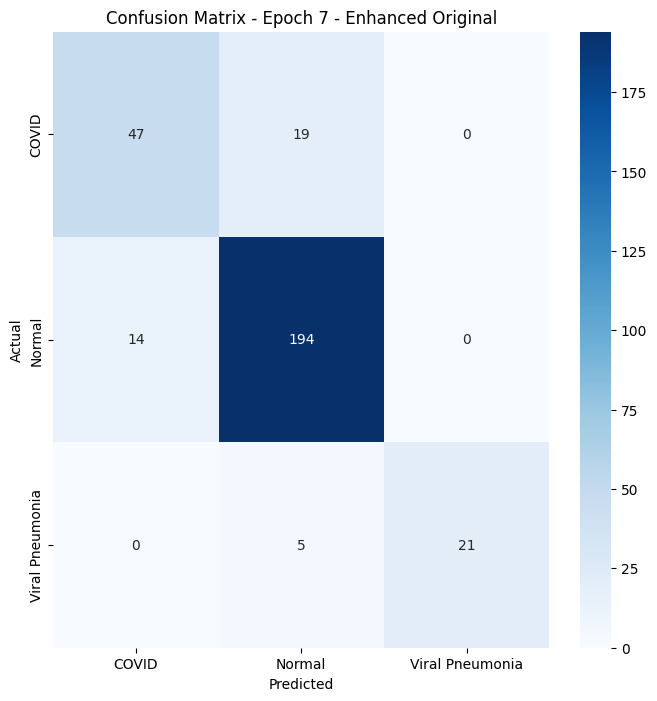

Epoch 8: Train Loss: 0.1051, Accuracy: 0.9625


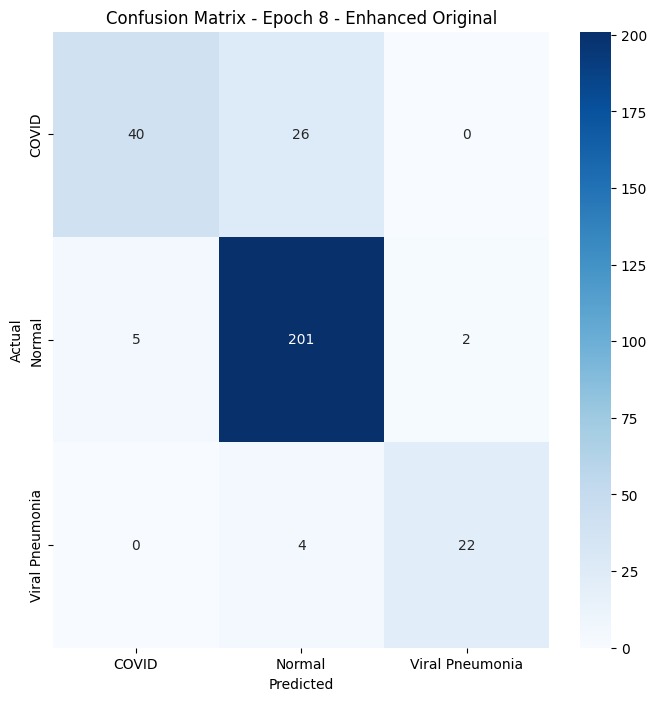

Epoch 9: Train Loss: 0.0932, Accuracy: 0.9633


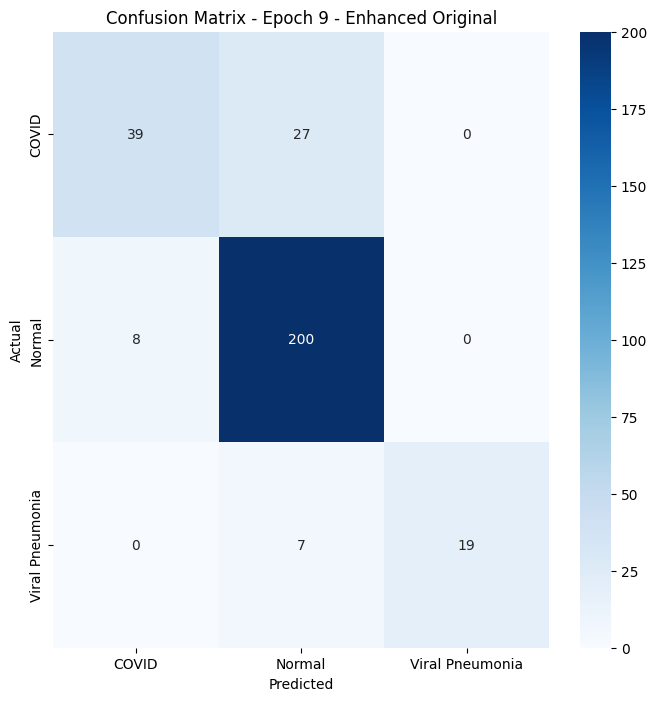

Epoch 10: Train Loss: 0.0804, Accuracy: 0.9750


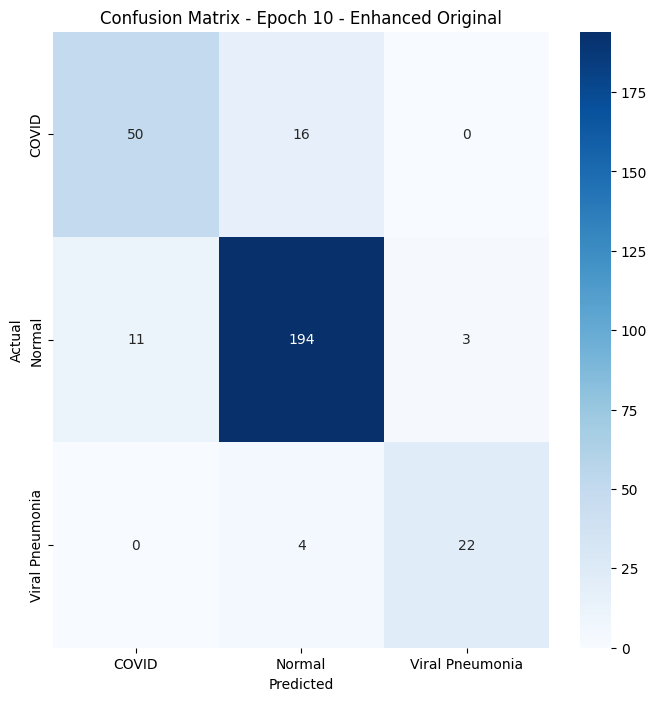

Epoch 11: Train Loss: 0.0358, Accuracy: 0.9942


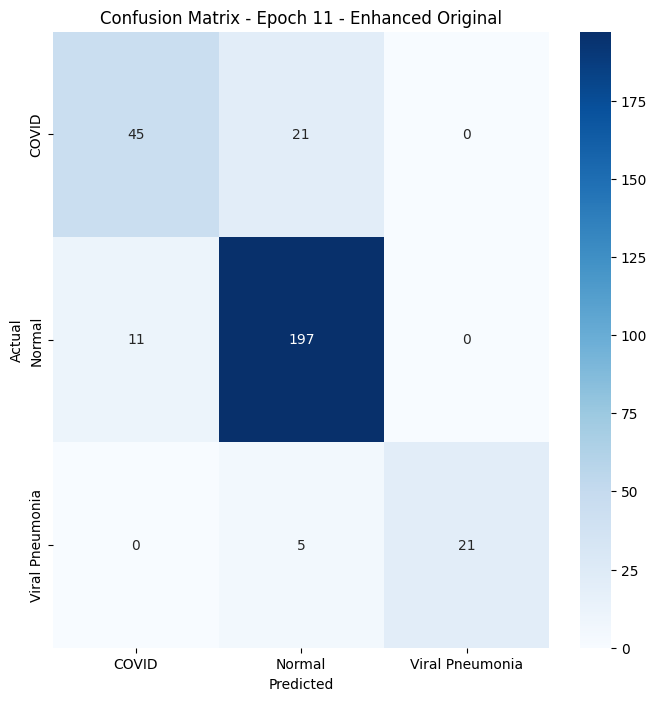

Epoch 12: Train Loss: 0.0257, Accuracy: 0.9958


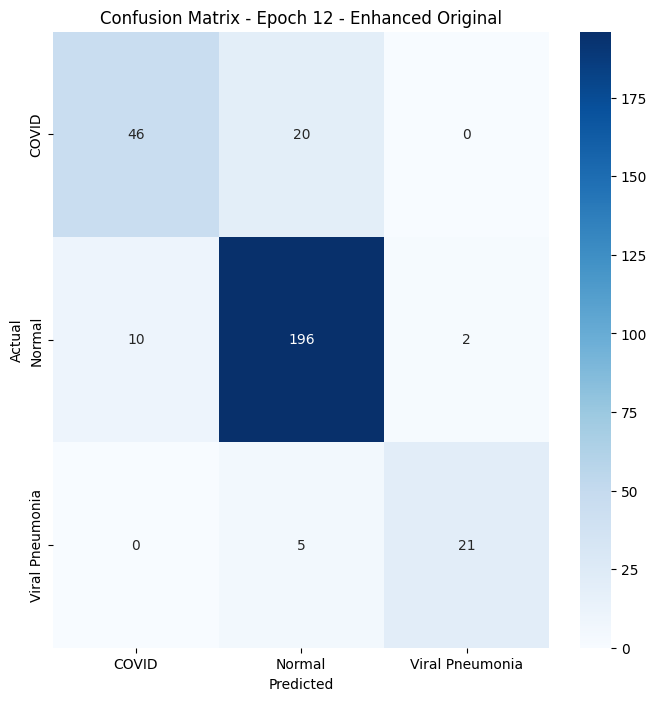

Epoch 13: Train Loss: 0.0204, Accuracy: 0.9983


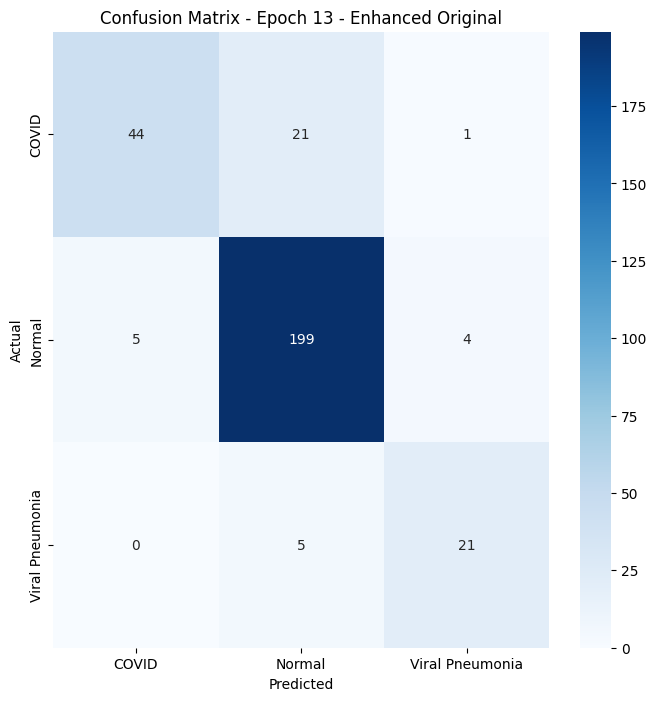

Epoch 14: Train Loss: 0.0125, Accuracy: 0.9992


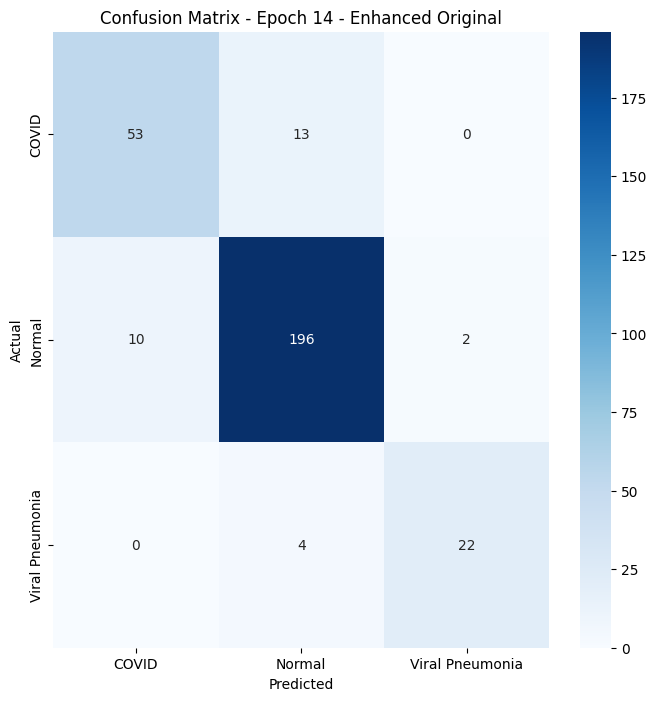

Epoch 15: Train Loss: 0.0063, Accuracy: 1.0000


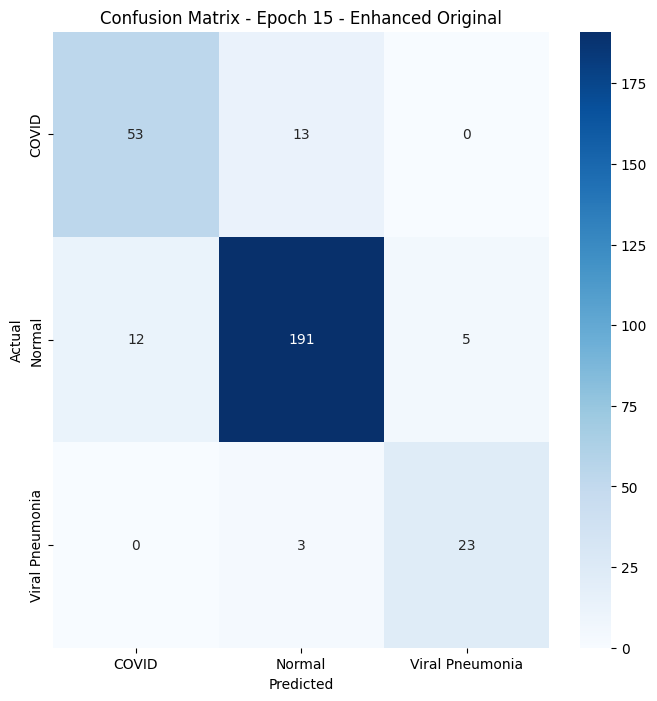

Epoch 16: Train Loss: 0.0036, Accuracy: 1.0000


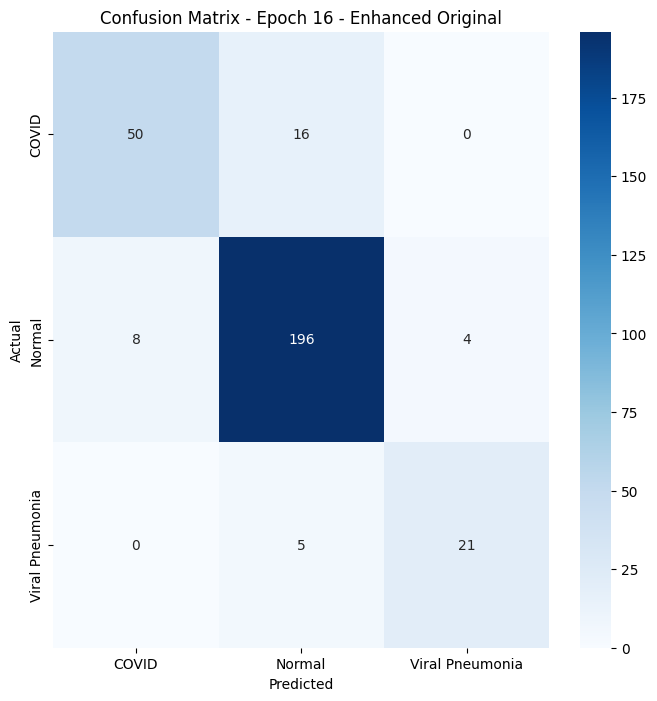

Epoch 17: Train Loss: 0.0025, Accuracy: 1.0000


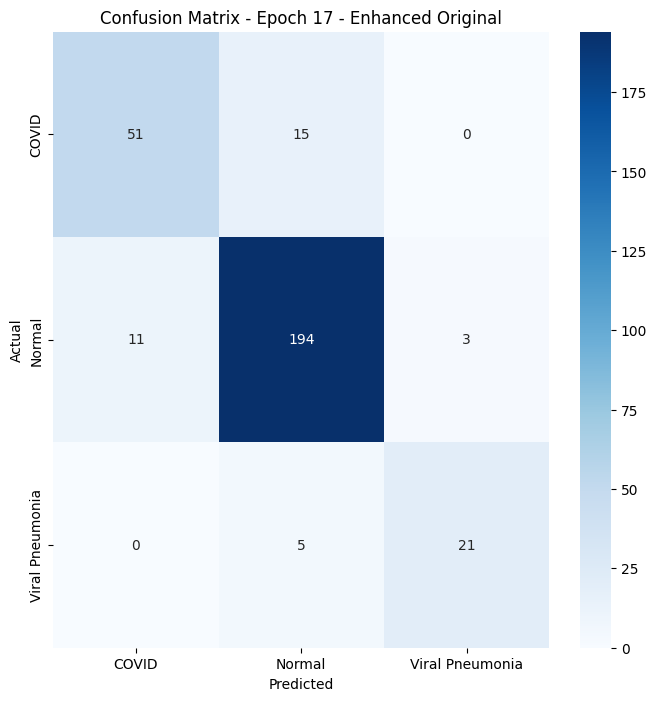

Epoch 18: Train Loss: 0.0019, Accuracy: 1.0000


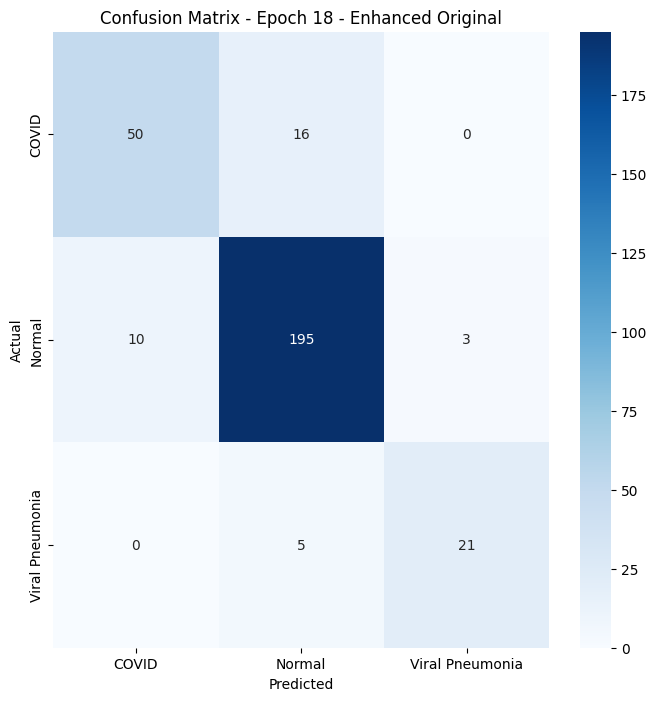

Epoch 19: Train Loss: 0.0017, Accuracy: 1.0000


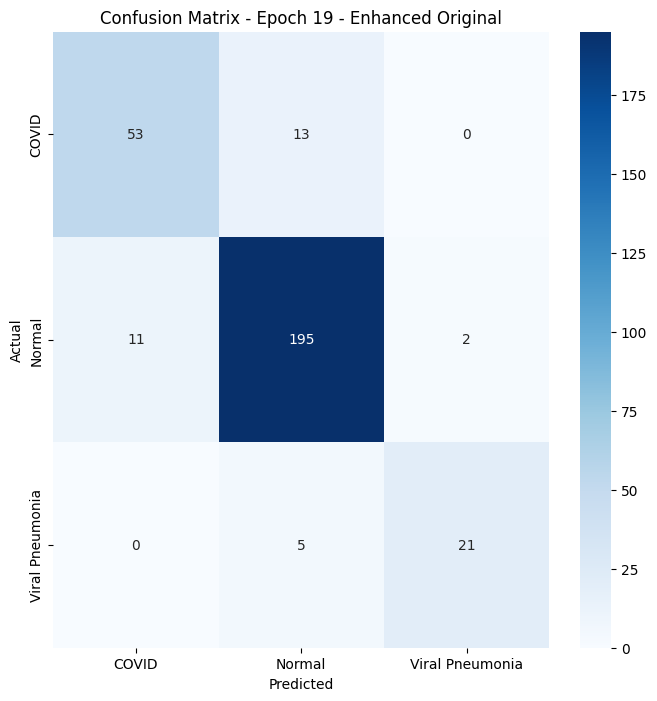

Epoch 20: Train Loss: 0.0013, Accuracy: 1.0000


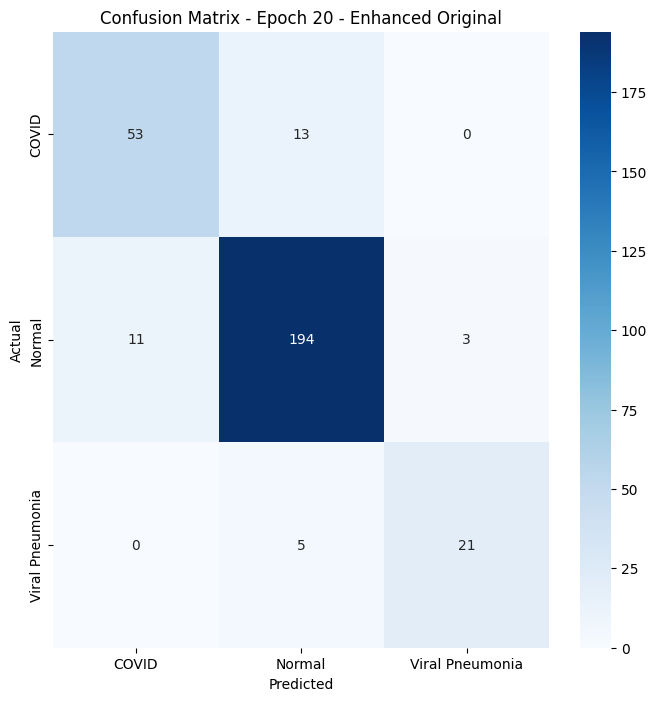

In [15]:
enhanced_og_metrics = train_and_evaluate(enhanced_train_og_loader, enhanced_test_og_loader, "Enhanced Original", class_names)

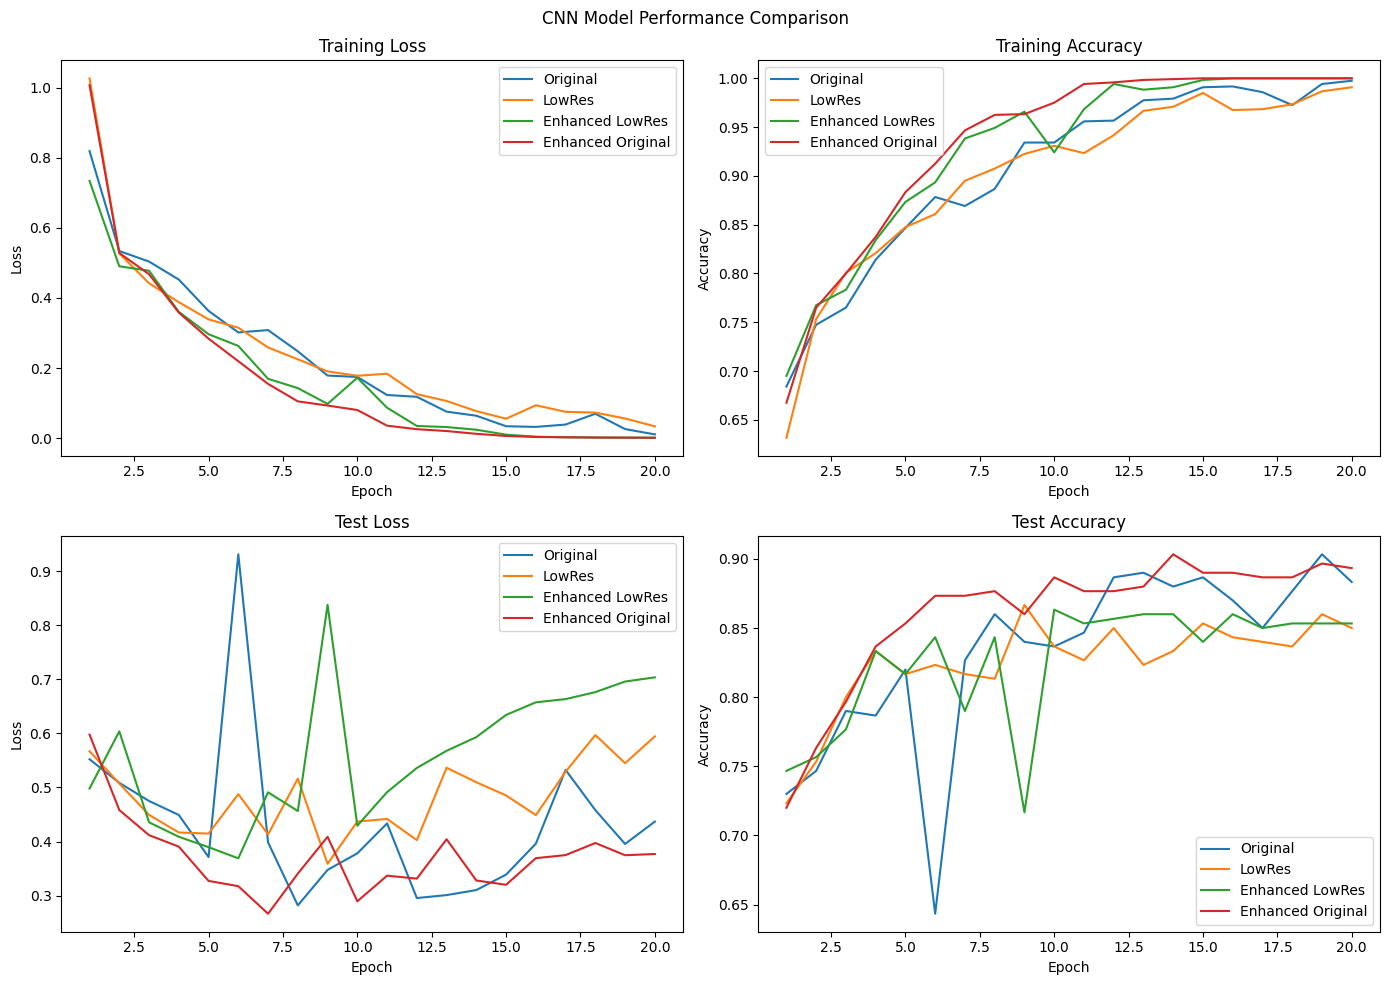

In [16]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # note that my kernel crashes when plotting if I don't have this line due to duplicate dll files in the ananconda environment

labels = ['Original', 'LowRes', 'Enhanced LowRes', 'Enhanced Original']
metrics = [orig_metrics, lowres_metrics, enhanced_lowres_metrics, enhanced_og_metrics]
epochs = list(range(1, num_epochs + 1))

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("CNN Model Performance Comparison")

# training loss
for i, (train_losses, _, _, _) in enumerate(metrics):
    axs[0, 0].plot(epochs, train_losses, label=labels[i])
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

# training acc
for i, (_, train_accs, _, _) in enumerate(metrics):
    axs[0, 1].plot(epochs, train_accs, label=labels[i])
axs[0, 1].set_title("Training Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].legend()

# test loss
for i, (_, _, test_losses, _) in enumerate(metrics):
    axs[1, 0].plot(epochs, test_losses, label=labels[i])
axs[1, 0].set_title("Test Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].legend()

# test acc
for i, (_, _, _, test_accs) in enumerate(metrics):
    axs[1, 1].plot(epochs, test_accs, label=labels[i])
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].legend()

plt.tight_layout()
plt.show()
